## 1. Download/Load SP500 stocks prices data

In [2]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [5]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

In [10]:
sp500['Symbol'] = sp500['Symbol'].str.replace(".", "-")

symbols_list = sp500['Symbol'].unique().tolist()

In [12]:
end_date = '2023-11-30'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

In [14]:
df = yf.download(tickers=symbols_list, start=start_date, end=end_date)

[*********************100%***********************]  503 of 503 completed

ERROR 
1 Failed download:
ERROR ['NRG']: Exception('NRG: No price data found, symbol may be delisted (1d 2015-12-02 00:00:00 -> 2023-11-30)')


In [16]:
df = df.stack()
df.index.names = ['date', 'ticker']
df.index = df.index.set_levels([pd.to_datetime(df.index.levels[0]), df.index.levels[1]])
df.columns = df.columns.str.lower()

In [19]:
df.head()

adj close      close       high        low  \
date                ticker                                               
2015-12-02 00:00:00 A       37.841976  40.419998  41.459999  40.369999   
                    AAL     41.876389  43.820000  44.529999  43.529999   
                    AAPL    26.465128  29.070000  29.527500  29.020000   
                    ABBV    40.855934  57.720001  59.389999  57.369999   
                    ABT     38.927639  45.220001  45.720001  45.119999   

                                 open       volume  
date                ticker                          
2015-12-02 00:00:00 A       41.070000    4713200.0  
                    AAL     44.090000    8010400.0  
                    AAPL    29.334999  133546400.0  
                    ABBV    59.169998    7663000.0  
                    ABT     45.430000    4840400.0

## 2. Calculate features and technical indicators for each stock

In [ ]:
# Techincal Indicators
# Garman-Klass Volatility, RSI, Bollinger Bands, ATR, MACD, Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [20]:
# Garman-Klass Volatility
df['garman-klass-vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2 - \
                    (2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

In [22]:
# RSI
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

#df.xs('AAPL', level=1)['rsi'].plot()

In [27]:
# Bollinger Bands
# pandas_ta.bbands(close=df.xs('AAPL', level=1)['adj close'], length=20)

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

In [30]:
# ATR
# pandas_ta.atr(high=df['high'], low=df['low'], close=df['adj close'], length=14)

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], 
                        close=stock_data['adj close'], length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

In [32]:
# MACD
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

In [34]:
# Dollar Value (Turnover)
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [85]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                         'high', 'low', 'close']]

# Average dollar volume for each month
# df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')

In [91]:
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
    df.unstack()[last_cols].resample('M').last().stack('ticker')],
          axis = 1)).dropna()

In [92]:
# Calculate 5-year rolling average of dollar volume for each stocks before filtering

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

In [93]:
# Choose top 150 stocks by volume and drop unnecessary columns
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [95]:
# g = df.xs('AAPL', level=1)

def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close'].pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                      upper=x.quantile(1-outlier_cutoff))).add(1).pow(1/lag).sub(1))
        
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

In [96]:
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-12-31 AAL      50.711880  0.975345  3.972856  3.884601  3.928729   
           AAPL     40.006573 -0.679258  3.754309  3.703448  3.728878   
           ABBV     73.694954  1.681838  4.338743  4.289143  4.313943   
           ABT      51.533810  0.310912  3.978439  3.904342  3.941390   
           ACN     140.201736  0.777544  4.967737  4.907500  4.937618   
...                       ...       ...       ...       ...       ...   
2023-11-30 WMT     155.502457 -1.991180  5.149333  5.023587  5.086460   
           XOM     102.339996 -1.414792  4.682348  4.626921  4.654634   
           MRNA     79.010002 -0.636959  4.417111  4.246413  4.331762   
           UBER     56.400002 -0.660062  4.110388  3.834862  3.972625   
           ABNB    126.480003 -0.875970  4.903423  4.745869  4.824646   

                   garman-klass-vol      macd        rsi  return_1m  \
date       ticker                                                     
2017-12-31 AAL            -0.000305  1.250036  59.214251   0.030501   
           AAPL           -0.001526 -0.224382  47.784558  -0.015246   
           ABBV           -0.031544  0.195027  55.000892  -0.002167   
           ABT            -0.004710  0.252694  59.877776   0.012418   
           ACN            -0.003561  0.291734  65.003470   0.034322   
...                             ...       ...        ...        ...   
2023-11-30 WMT             0.000035 -1.465727  42.370164  -0.044856   
           XOM             0.000272 -1.056021  41.103883  -0.024319   
           MRNA            0.000326 -0.209604  45.621435   0.040153   
           UBER            0.000150  2.141278  74.225885   0.303142   
           ABNB            0.000373  0.322215  51.151824   0.069237   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-12-31 AAL      0.055325   0.031653   0.006292   0.023994    0.009787  
           AAPL     0.002359   0.032902   0.028535   0.019684    0.033479  
           ABBV     0.035171   0.031007   0.051953   0.047851    0.039985  
           ABT      0.025851   0.024323   0.028884   0.030147    0.035524  
           ACN      0.037001   0.045983   0.037860   0.029824    0.024265  
...                      ...        ...        ...        ...         ...  
2023-11-30 WMT     -0.012110  -0.013569   0.010786   0.011741    0.003249  
           XOM     -0.062799  -0.024312   0.003143  -0.005038   -0.004217  
           MRNA    -0.125395  -0.112616  -0.076913  -0.060695   -0.064524  
           UBER     0.107408   0.060931   0.068356   0.060435    0.056572  
           ABNB    -0.039897  -0.013015   0.023897   0.002851    0.017971  

[10347 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [97]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

In [98]:
factor_data = factor_data.resample('M').last().div(100)

In [100]:
factor_data.index.name = 'date'
factor_data =factor_data.join(data['return_1m']).sort_index()

In [ ]:
# Check for correct join
# factor_data.xs("AAPL", level=1)
# factor_data.xs("MSFT", level=1)

In [105]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations>=10]

In [108]:
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

In [109]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-12-31 AAL     0.0106 -0.0107  0.0006  0.0074  0.0169   0.030501
           AAPL    0.0106 -0.0107  0.0006  0.0074  0.0169  -0.015246
           ABBV    0.0106 -0.0107  0.0006  0.0074  0.0169  -0.002167
           ABT     0.0106 -0.0107  0.0006  0.0074  0.0169   0.012418
           ACN     0.0106 -0.0107  0.0006  0.0074  0.0169   0.034322
...                   ...     ...     ...     ...     ...        ...
2023-10-31 VRTX   -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.041324
           VZ     -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.107061
           WFC    -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.026676
           WMT    -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.021760
           XOM    -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.099762

[10155 rows x 6 columns]

In [115]:
# Calculate Rolling Factor betas
betas = factor_data.groupby(level=1, group_keys=False).apply(lambda x: RollingOLS(endog=x['return_1m'],
                                                                         exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                                                         window=min(24, x.shape[0]),
                                                                         min_nobs=len(x.columns)+1)
                                                    .fit(params_only=True)
                                                    .params.drop('const', axis=1))

In [117]:
data = data.join(betas.groupby('ticker').shift())

In [118]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data.loc[:, factors] = data.groupby(level=1, group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

In [121]:
data = data.dropna()
data = data.drop('adj close', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10122 entries, (Timestamp('2017-12-31 00:00:00'), 'AAL') to (Timestamp('2023-11-30 00:00:00'), 'UBER')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10122 non-null  float64
 1   bb_high           10122 non-null  float64
 2   bb_low            10122 non-null  float64
 3   bb_mid            10122 non-null  float64
 4   garman-klass-vol  10122 non-null  float64
 5   macd              10122 non-null  float64
 6   rsi               10122 non-null  float64
 7   return_1m         10122 non-null  float64
 8   return_2m         10122 non-null  float64
 9   return_3m         10122 non-null  float64
 10  return_6m         10122 non-null  float64
 11  return_9m         10122 non-null  float64
 12  return_12m        10122 non-null  float64
 13  Mkt-RF            10122 non-null  float64
 14  SMB               10122 non-null  float64
 15  HML       

## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [122]:
from sklearn.cluster import KMeans

In [123]:
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                          init='random',
                          random_state=0).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

In [124]:
data

atr   bb_high    bb_low    bb_mid  garman-klass-vol  \
date       ticker                                                             
2017-12-31 AAL     0.975345  3.972856  3.884601  3.928729         -0.000305   
           AAPL   -0.679258  3.754309  3.703448  3.728878         -0.001526   
           ABBV    1.681838  4.338743  4.289143  4.313943         -0.031544   
           ABT     0.310912  3.978439  3.904342  3.941390         -0.004710   
           ACN     0.777544  4.967737  4.907500  4.937618         -0.003561   
...                     ...       ...       ...       ...               ...   
2023-11-30 WFC    -1.470876  3.814444  3.703654  3.759049          0.000066   
           WMT    -1.991180  5.149333  5.023587  5.086460          0.000035   
           XOM    -1.414792  4.682348  4.626921  4.654634          0.000272   
           MRNA   -0.636959  4.417111  4.246413  4.331762          0.000326   
           UBER   -0.660062  4.110388  3.834862  3.972625          0.000150   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2017-12-31 AAL     1.250036  59.214251   0.030501   0.055325   0.031653   
           AAPL   -0.224382  47.784558  -0.015246   0.002359   0.032902   
           ABBV    0.195027  55.000892  -0.002167   0.035171   0.031007   
           ABT     0.252694  59.877776   0.012418   0.025851   0.024323   
           ACN     0.291734  65.003470   0.034322   0.037001   0.045983   
...                     ...        ...        ...        ...        ...   
2023-11-30 WFC     0.955361  63.883648   0.110644   0.039719   0.022732   
           WMT    -1.465727  42.370164  -0.044856  -0.012110  -0.013569   
           XOM    -1.056021  41.103883  -0.024319  -0.062799  -0.024312   
           MRNA   -0.209604  45.621435   0.040153  -0.125395  -0.112616   
           UBER    2.141278  74.225885   0.303142   0.107408   0.060931   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-12-31 AAL      0.006292   0.023994    0.009787  1.251394  1.351929   
           AAPL     0.028535   0.019684    0.033479  1.298720 -0.301041   
           ABBV     0.051953   0.047851    0.039985  0.480770  0.427427   
           ABT      0.028884   0.030147    0.035524  0.822451 -0.179049   
           ACN      0.037860   0.029824    0.024265  1.209893 -0.166001   
...                      ...        ...         ...       ...       ...   
2023-11-30 WFC      0.018795  -0.004612   -0.005001  1.083115 -0.107031   
           WMT      0.010786   0.011741    0.003249  0.614307 -0.453121   
           XOM      0.003143  -0.005038   -0.004217  1.147252  0.300970   
           MRNA    -0.076913  -0.060695   -0.064524  1.244448  0.279488   
           UBER     0.068356   0.060435    0.056572  1.001644  1.371665   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-12-31 AAL     0.571306  0.376774  0.634713        3  
           AAPL   -0.613844  0.610141  0.538994        1  
           ABBV   -0.065085  0.300747  0.215049        2  
           ABT    -0.522298  0.273868  0.982861        3  
           ACN    -0.314893  0.278259  0.176484        3  
...                     ...       ...       ...      ...  
2023-11-30 WFC     1.399432 -0.735977 -0.553679        1  
           WMT    -0.310269  0.332420  0.716913        3  
           XOM     0.627967 -0.480462  0.696121        3  
           MRNA   -1.196473  0.880607  0.768168        3  
           UBER   -0.409393 -1.303400 -0.156893        0  

[10122 rows x 19 columns]

In [125]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


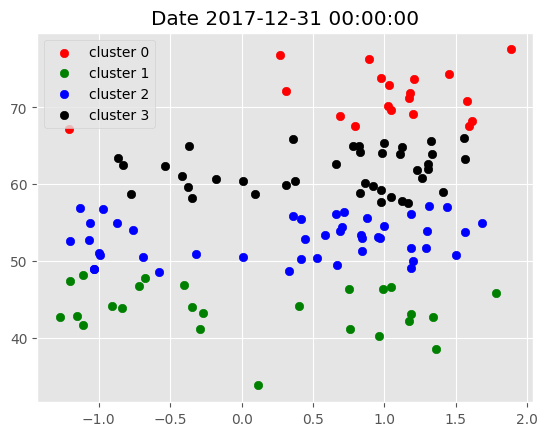

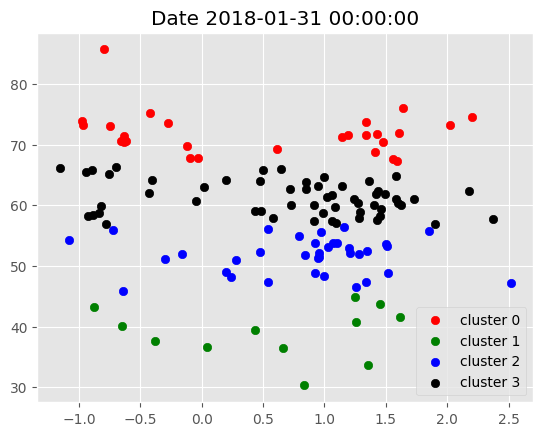

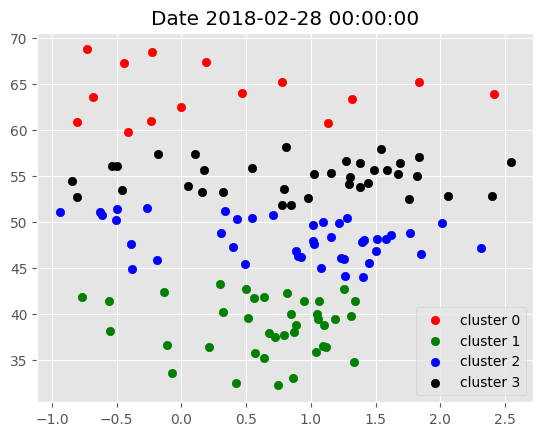

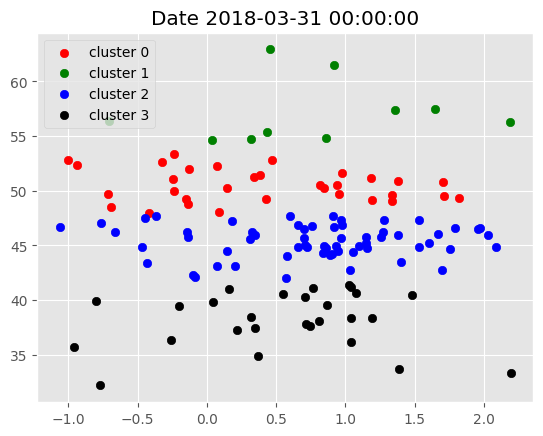

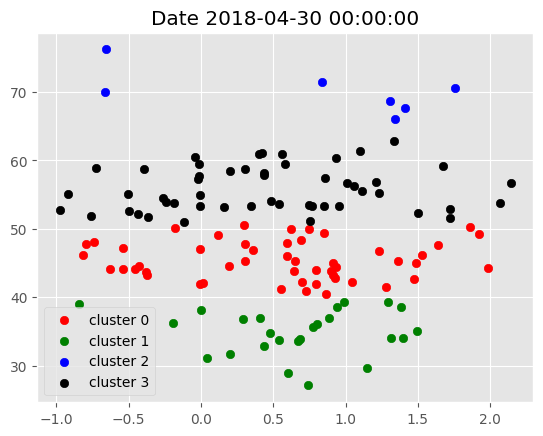

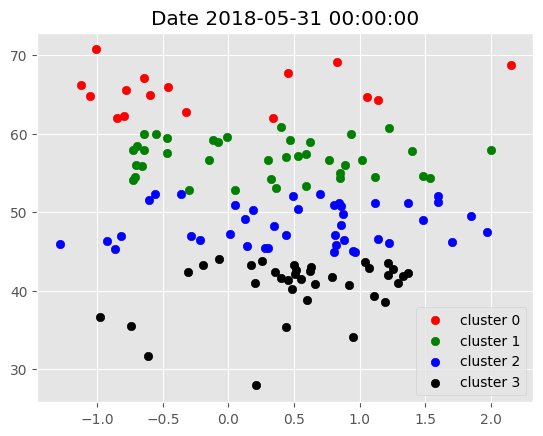

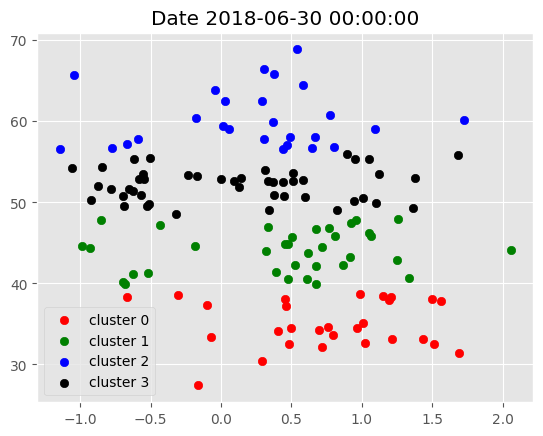

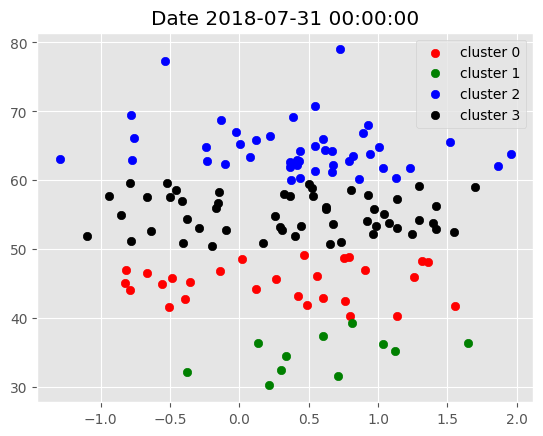

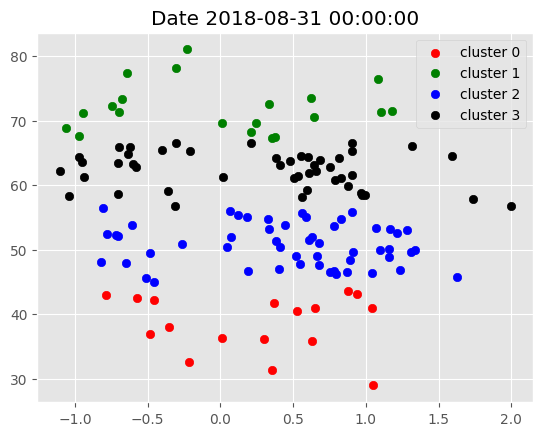

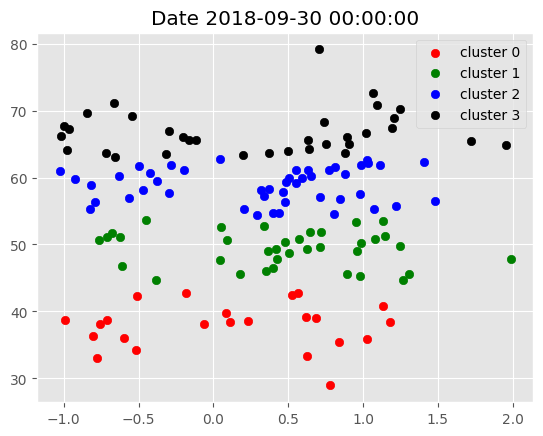

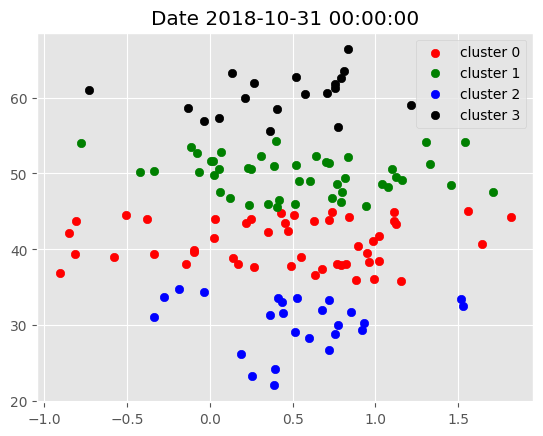

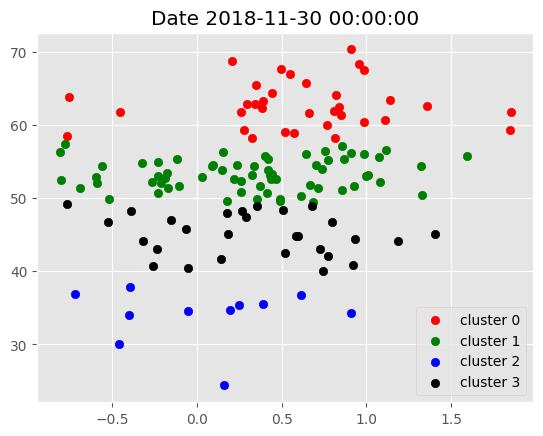

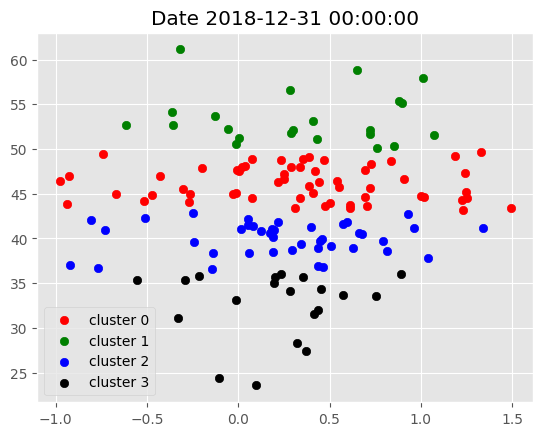

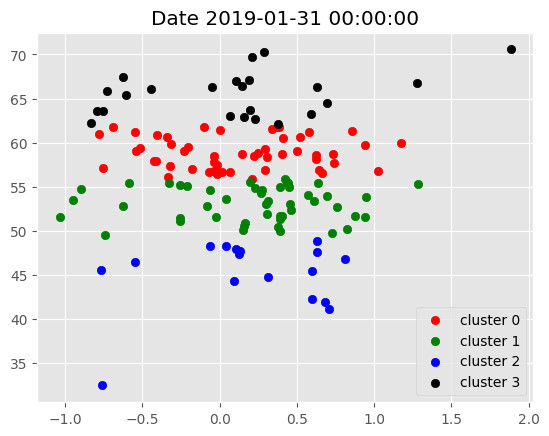

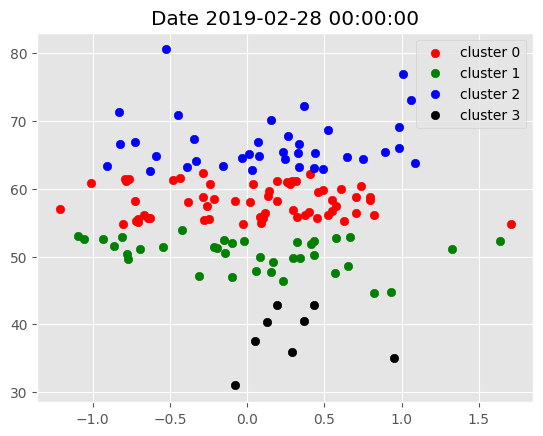

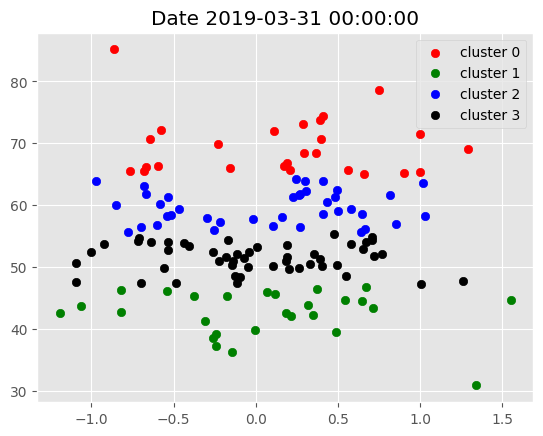

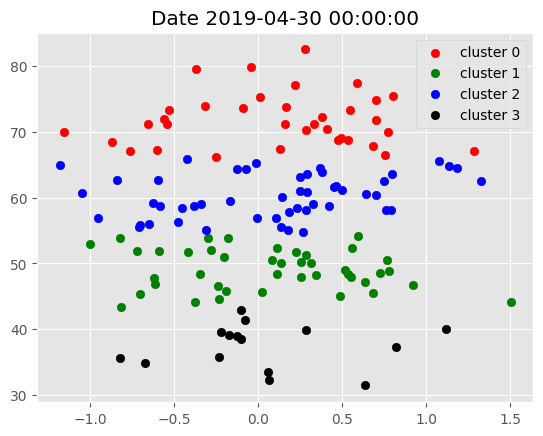

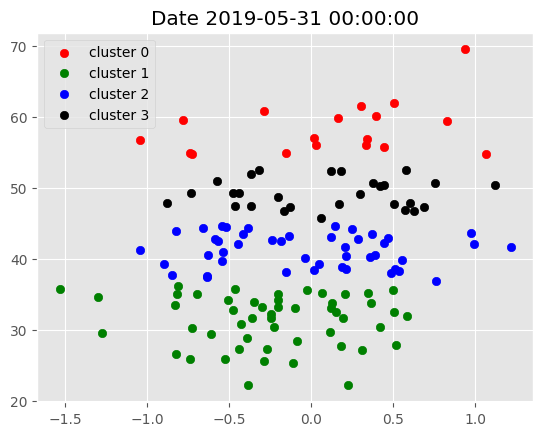

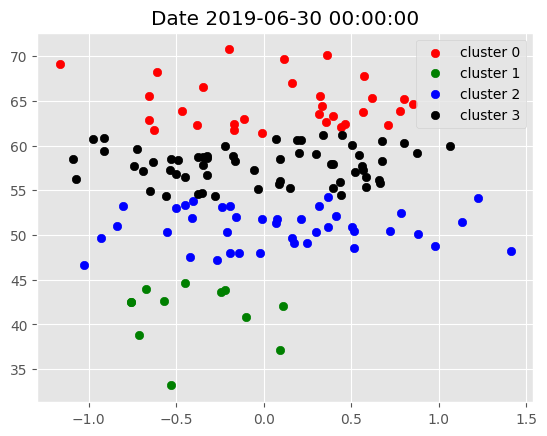

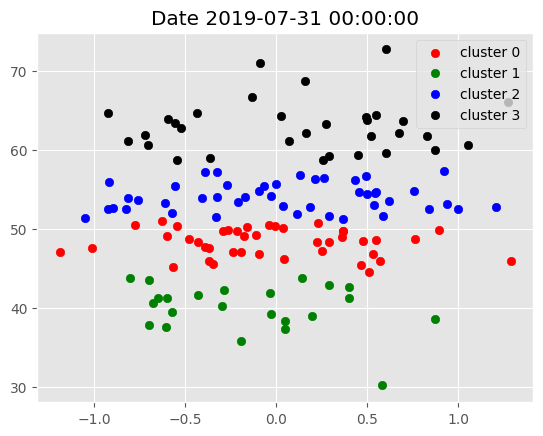

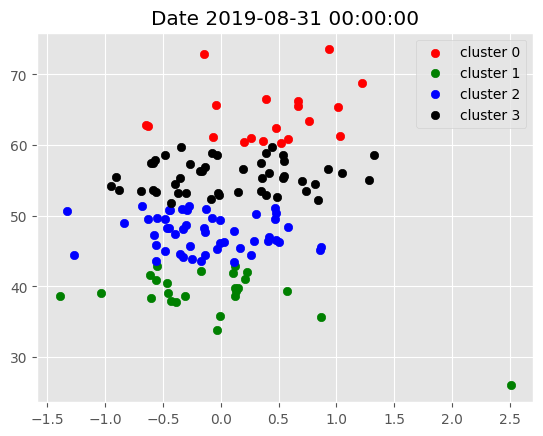

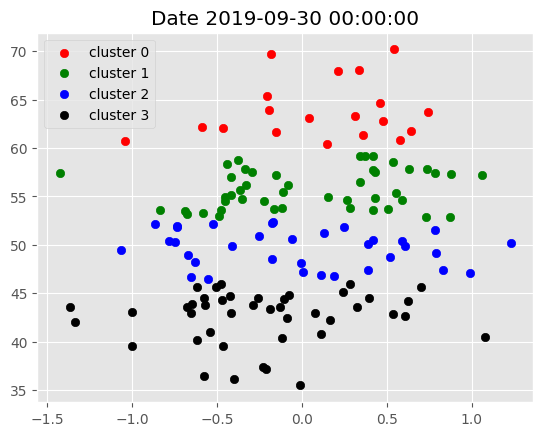

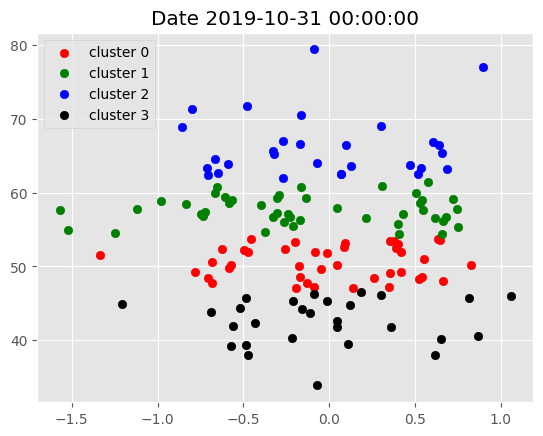

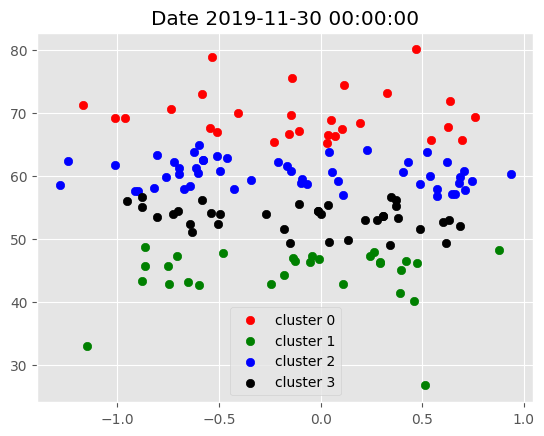

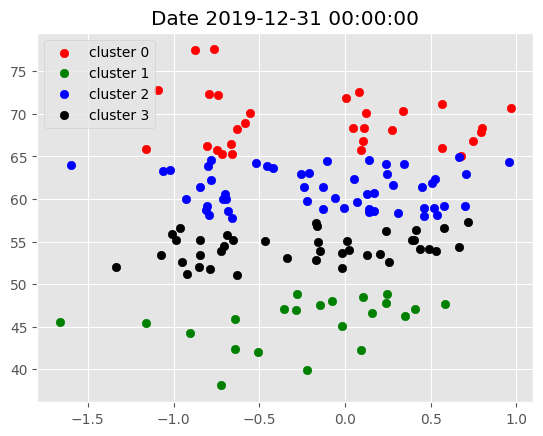

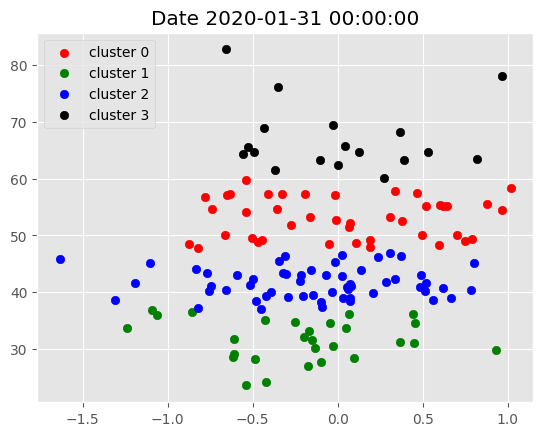

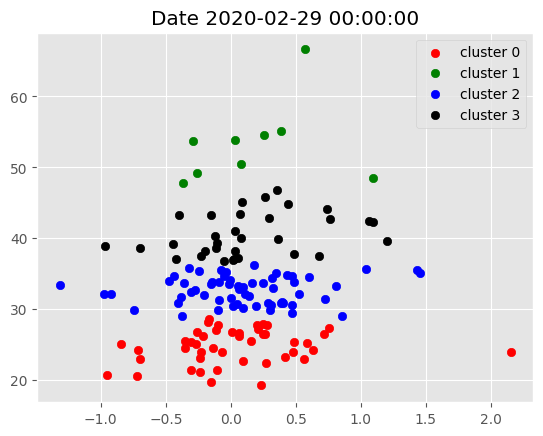

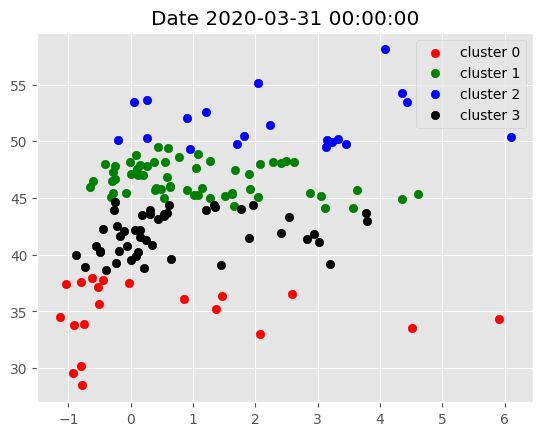

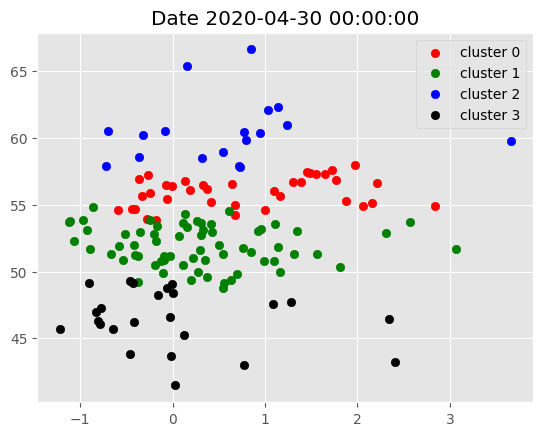

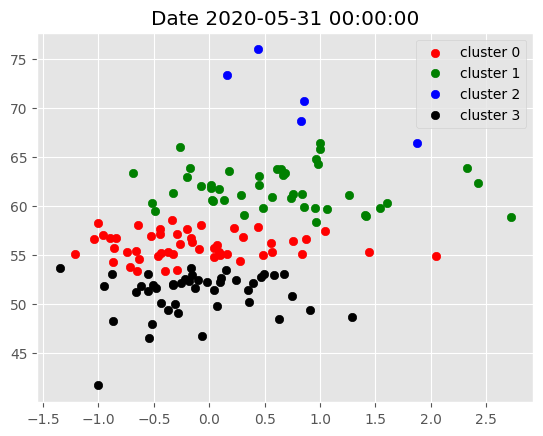

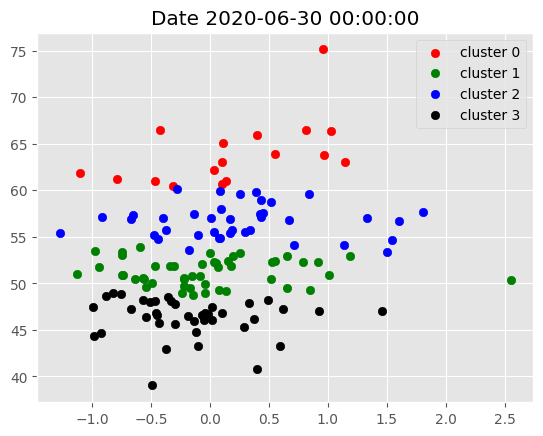

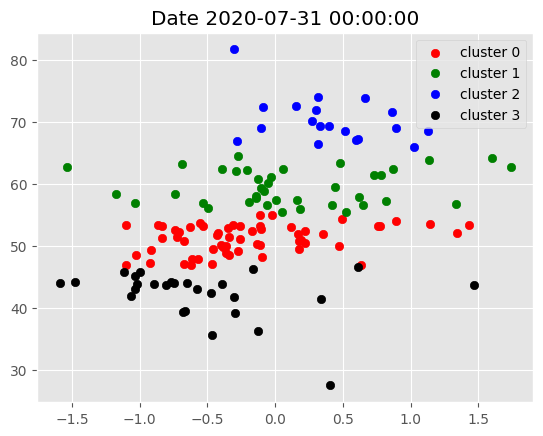

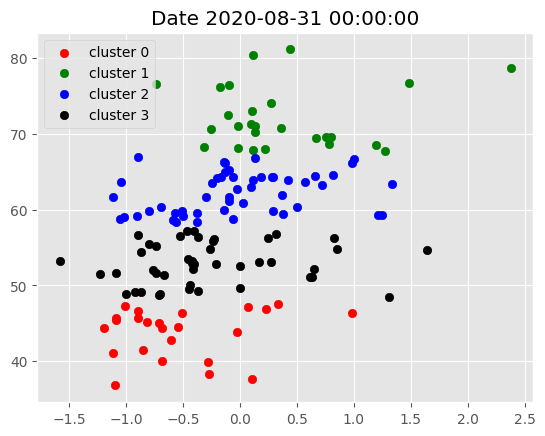

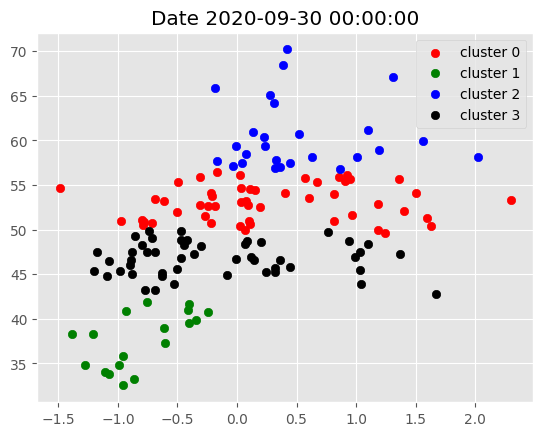

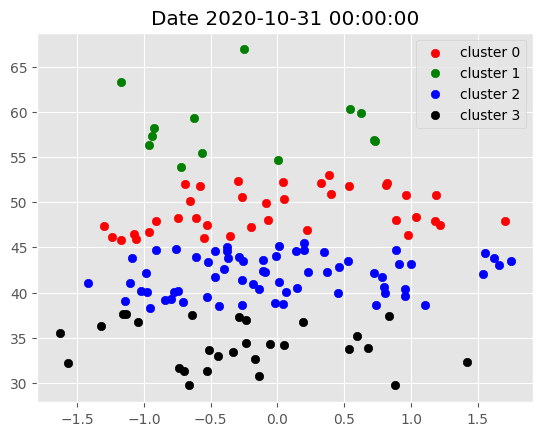

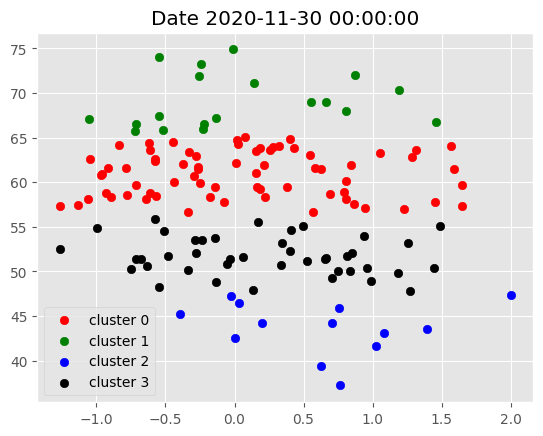

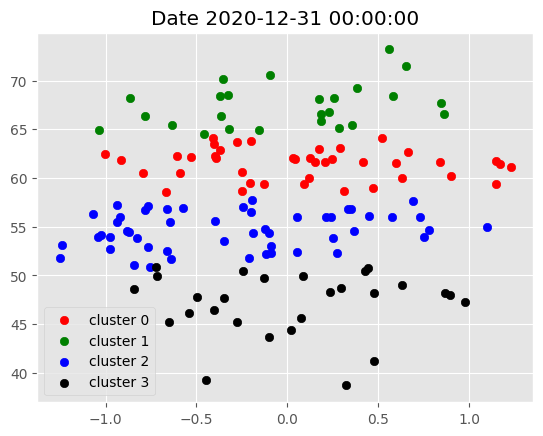

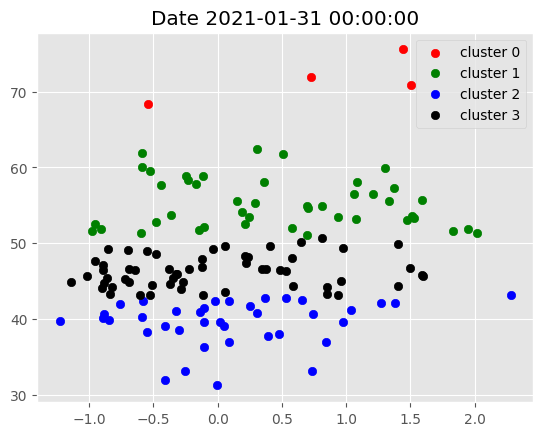

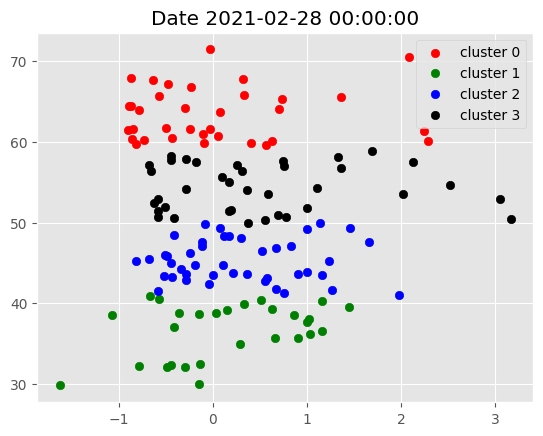

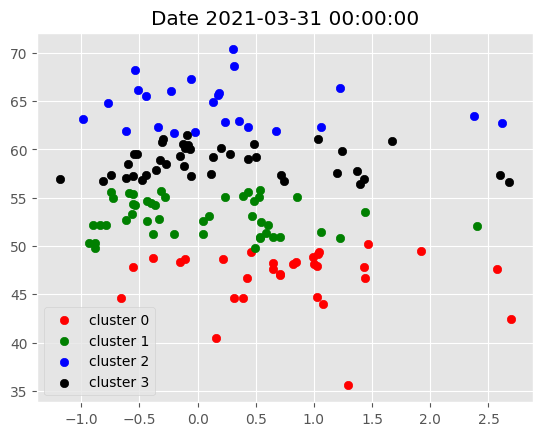

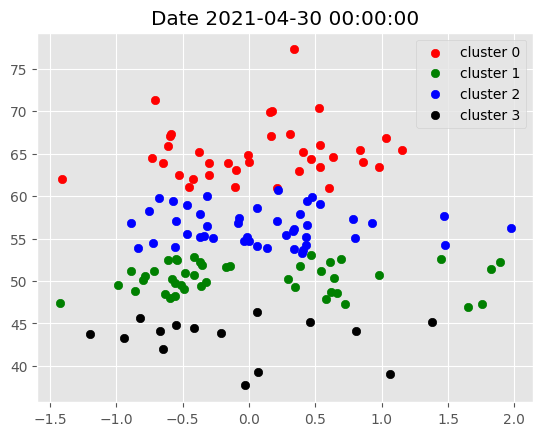

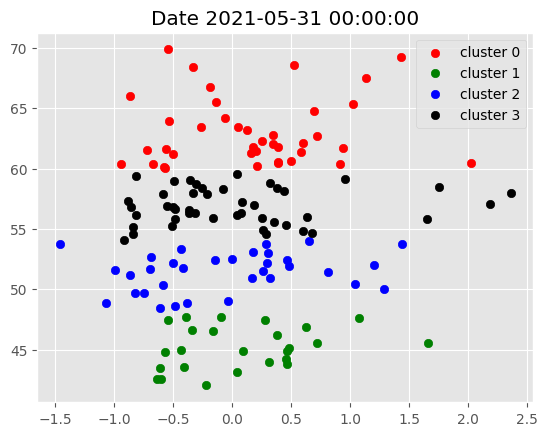

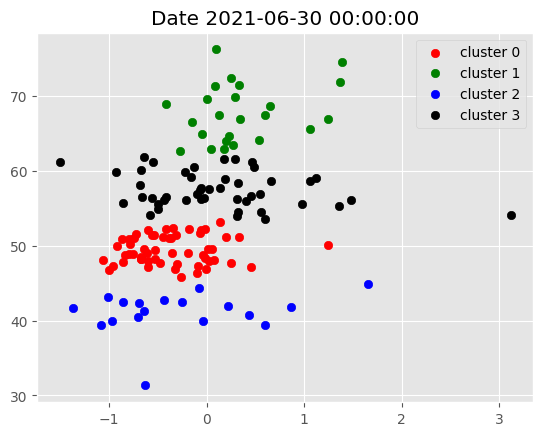

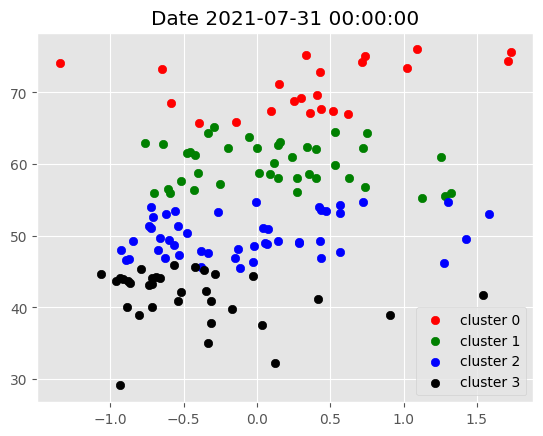

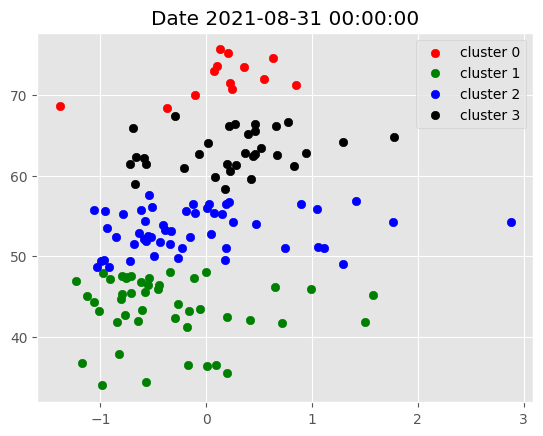

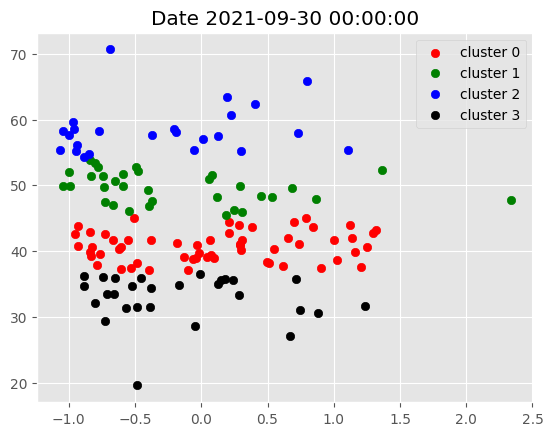

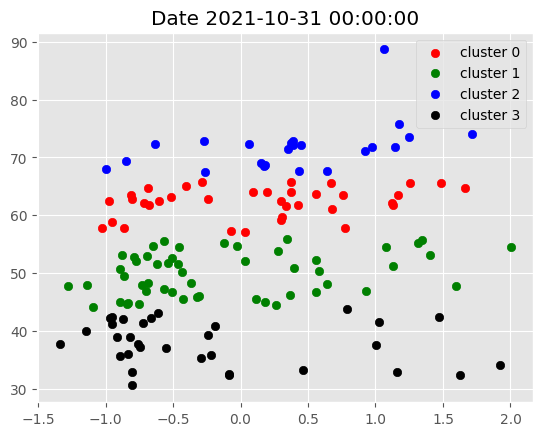

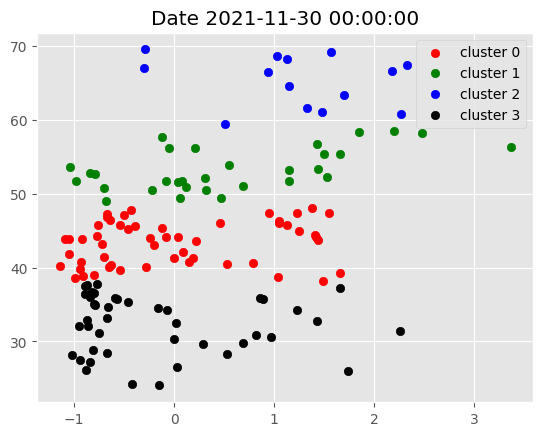

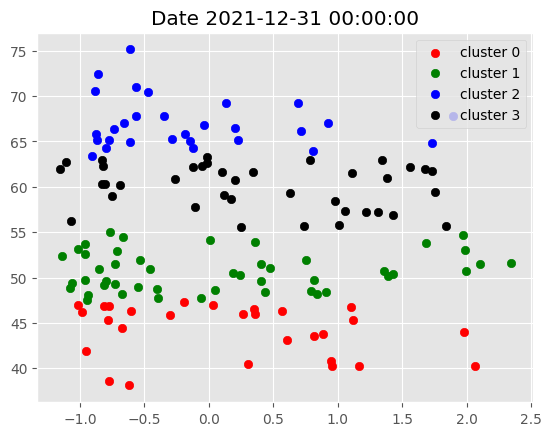

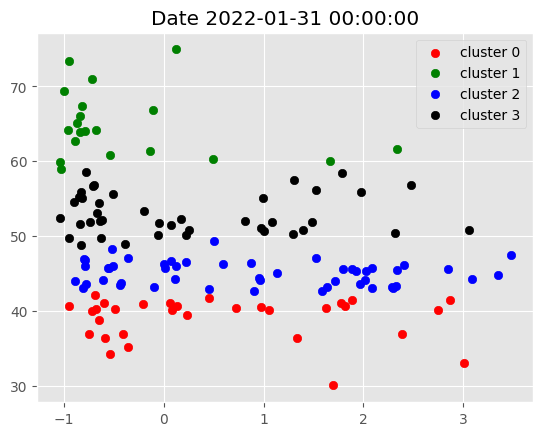

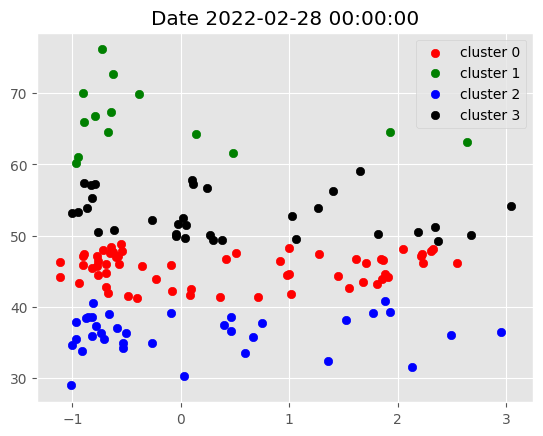

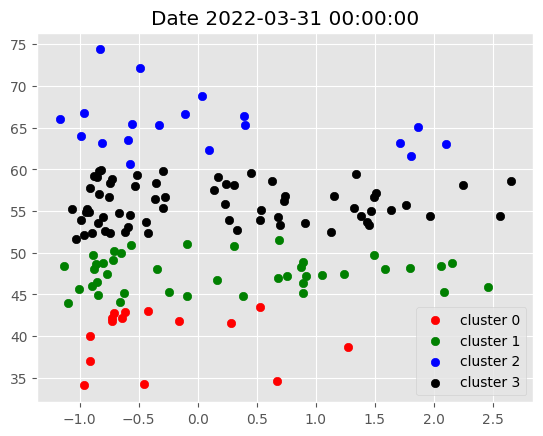

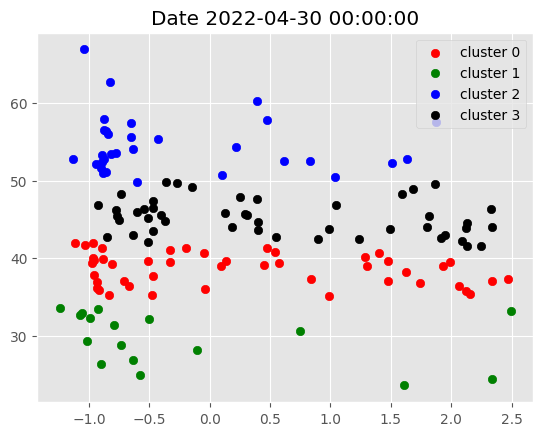

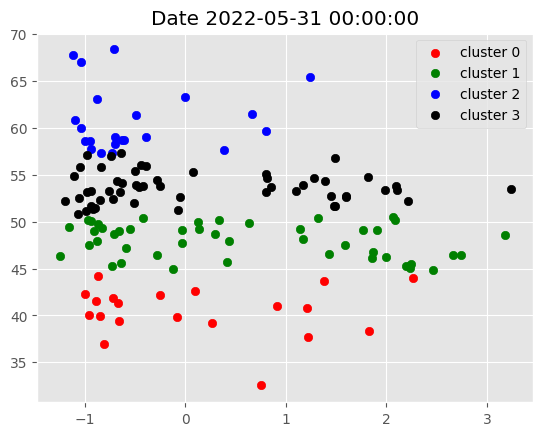

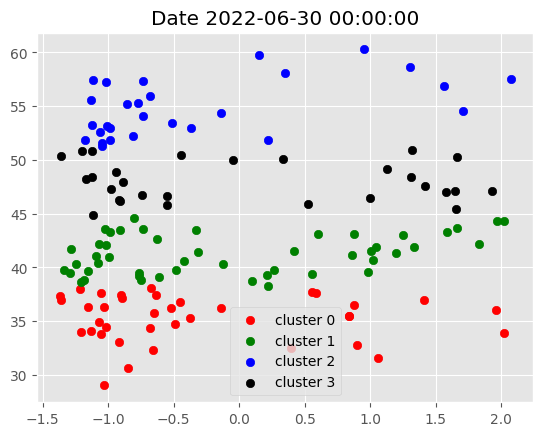

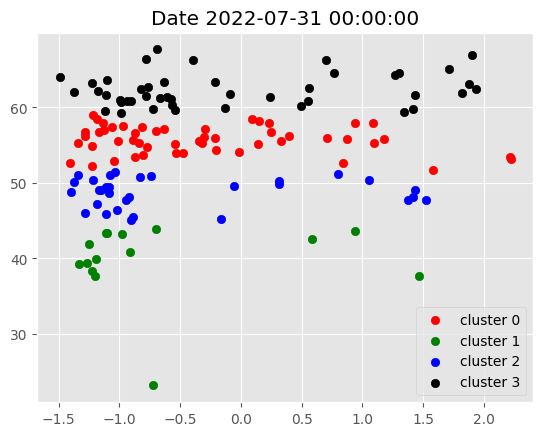

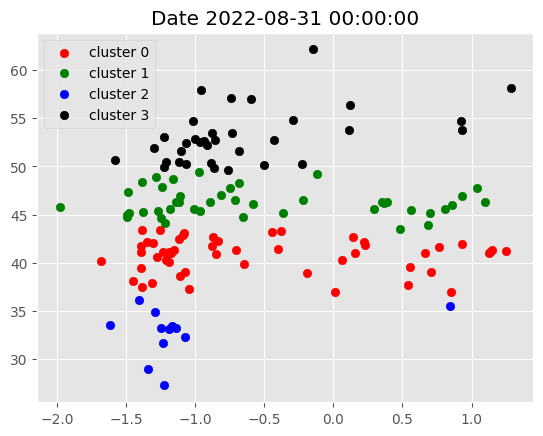

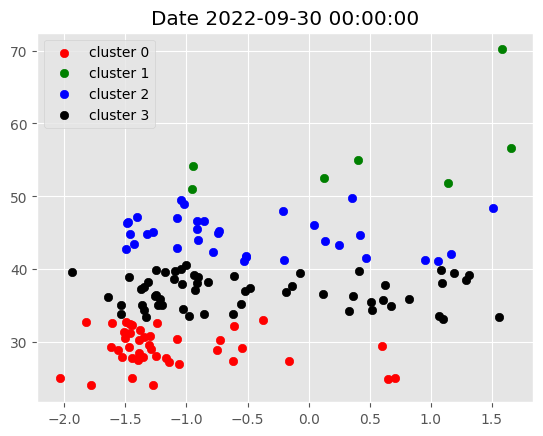

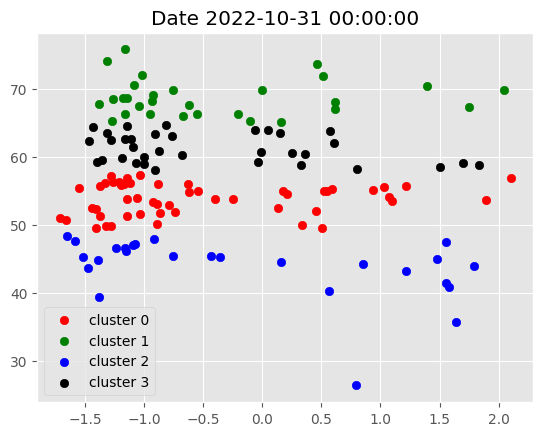

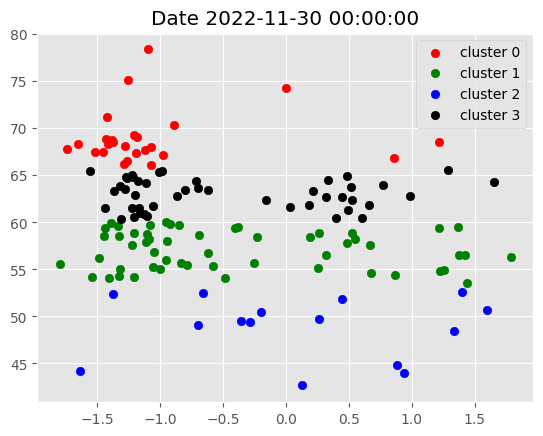

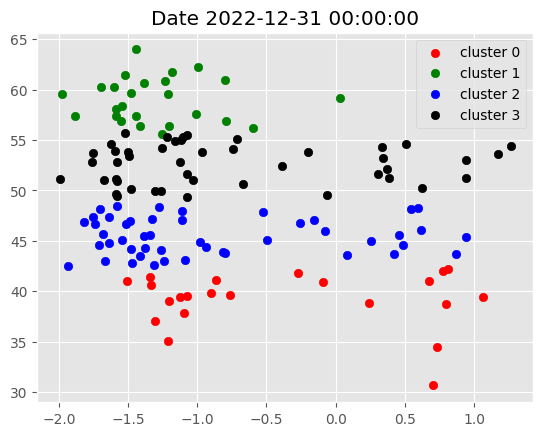

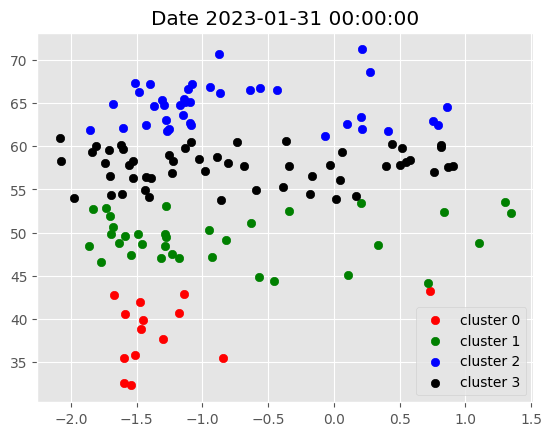

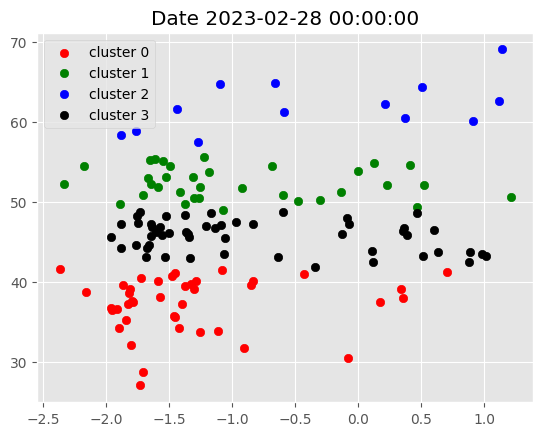

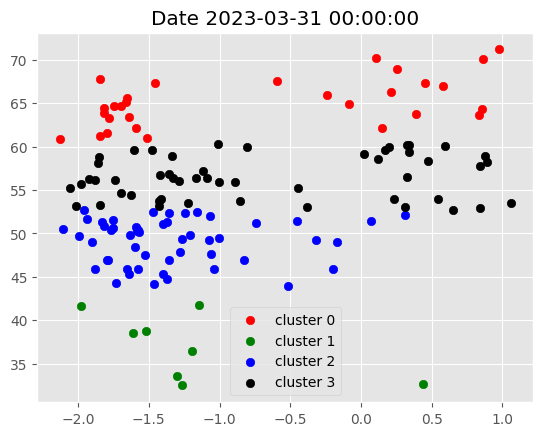

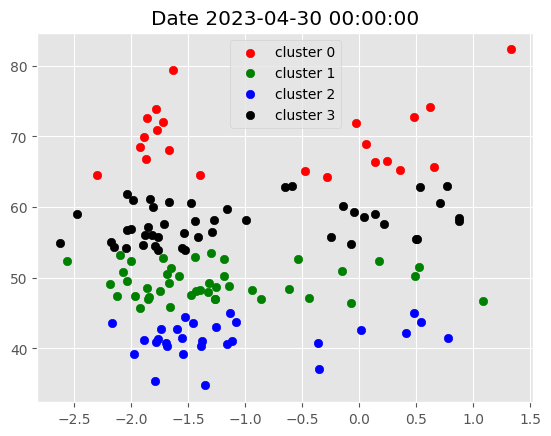

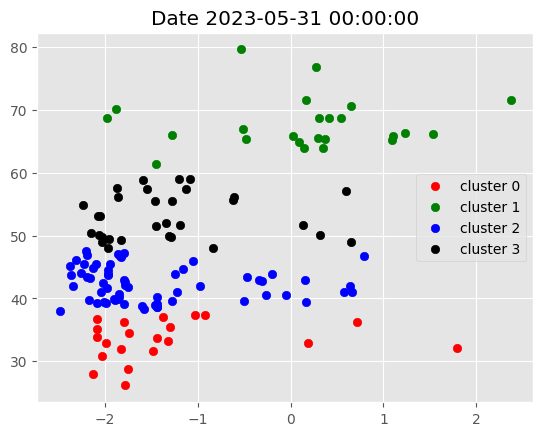

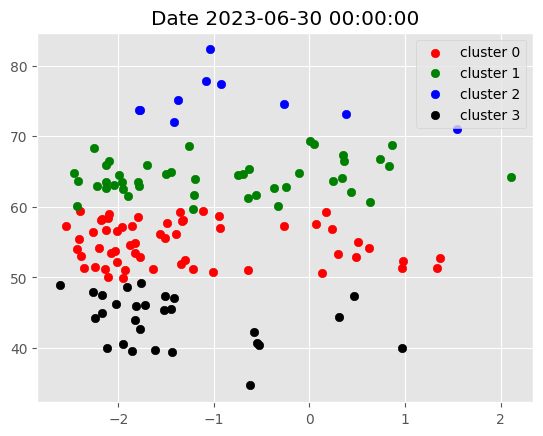

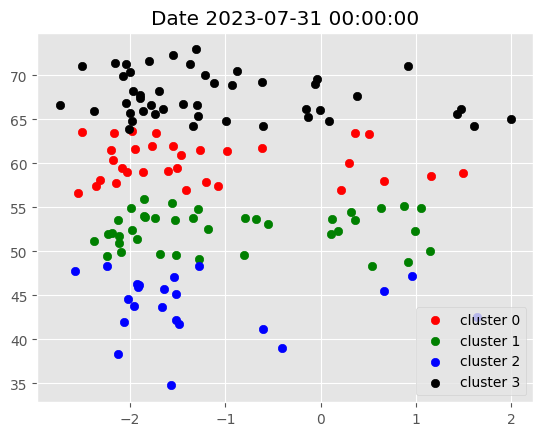

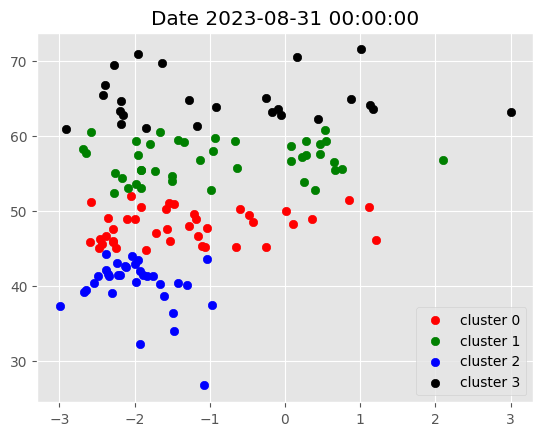

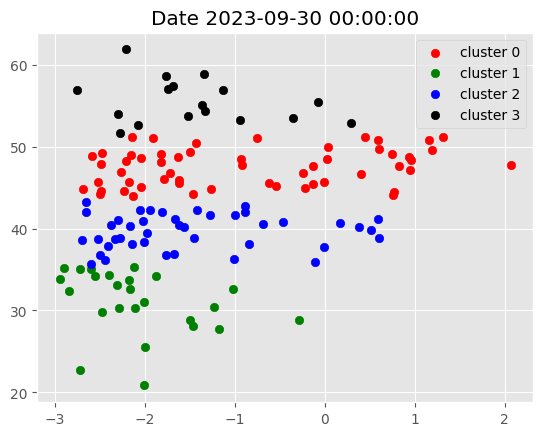

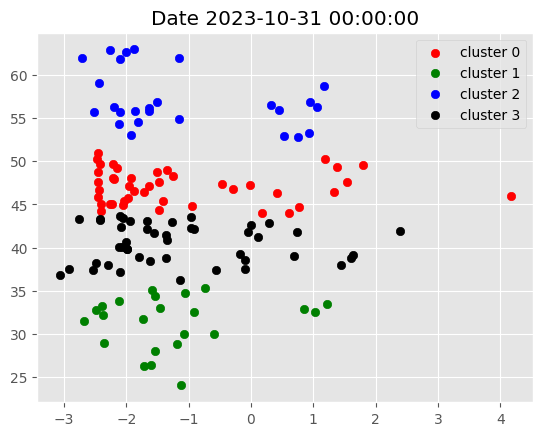

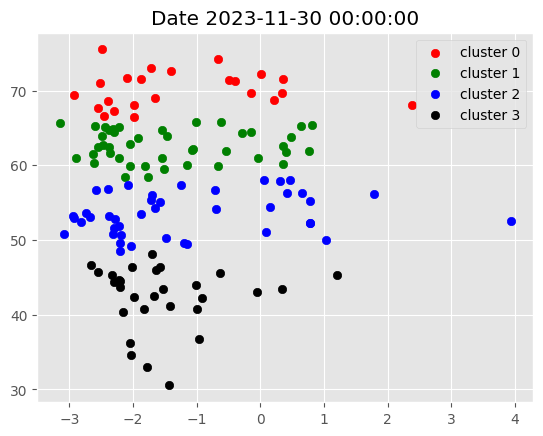

In [126]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f"Date {i}")
    plot_clusters(g)

In [127]:
# Apply pre-defined centroids
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))
initial_centroids[:, 6] = target_rsi_values

In [129]:
data = data.drop('cluster', axis=1)
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                          init=initial_centroids,
                          random_state=0).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

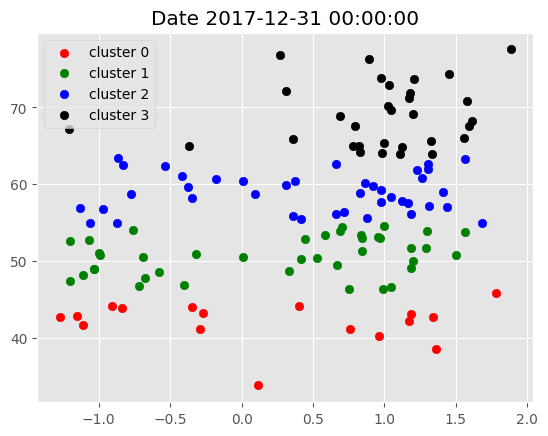

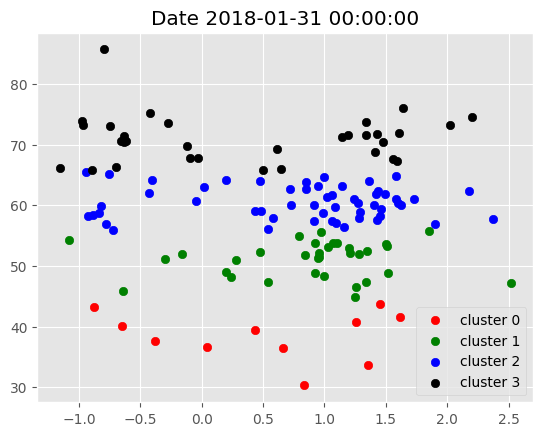

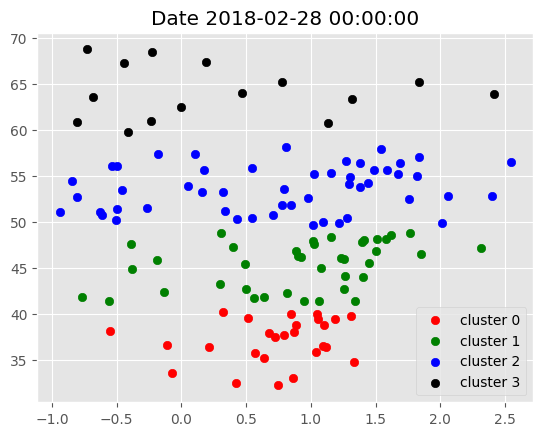

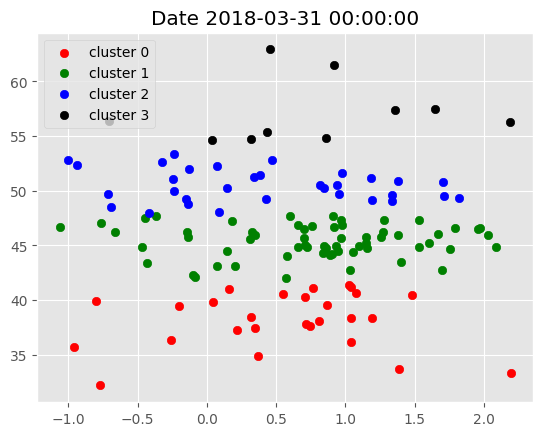

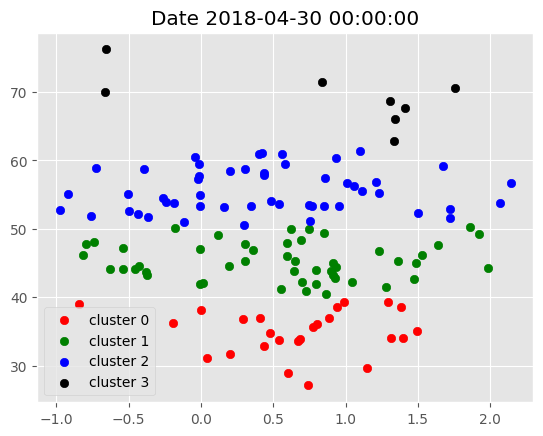

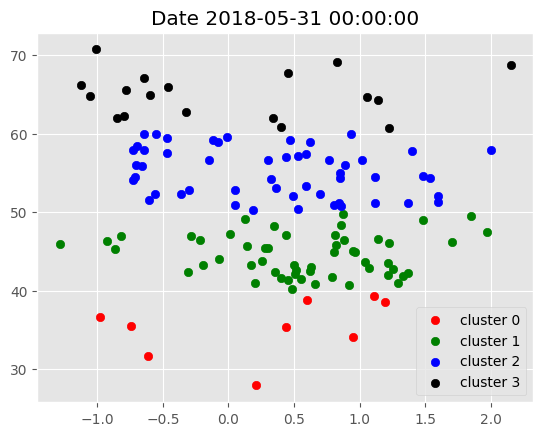

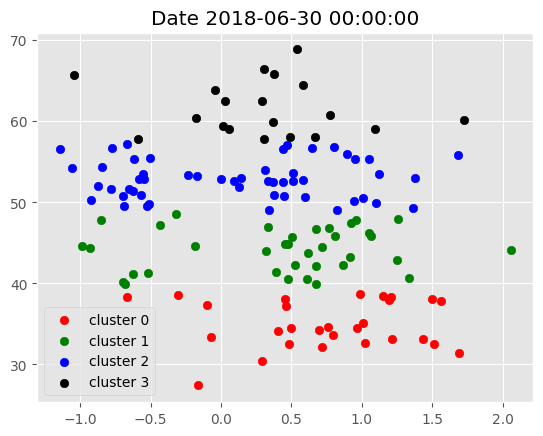

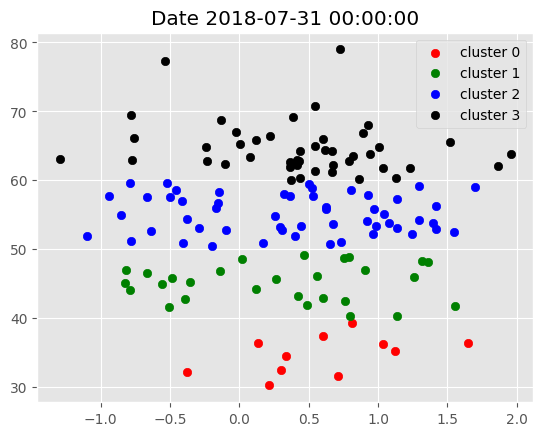

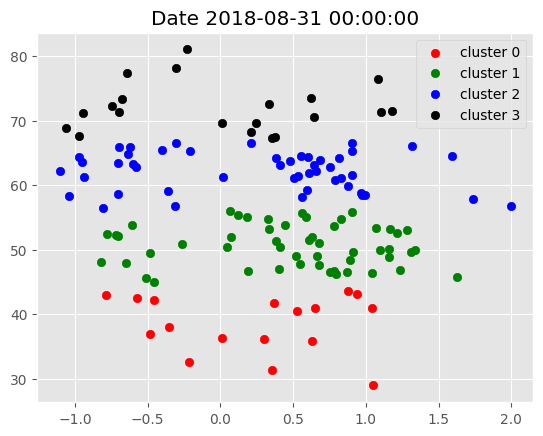

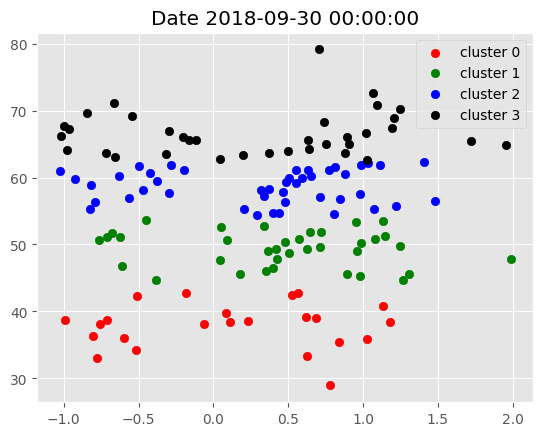

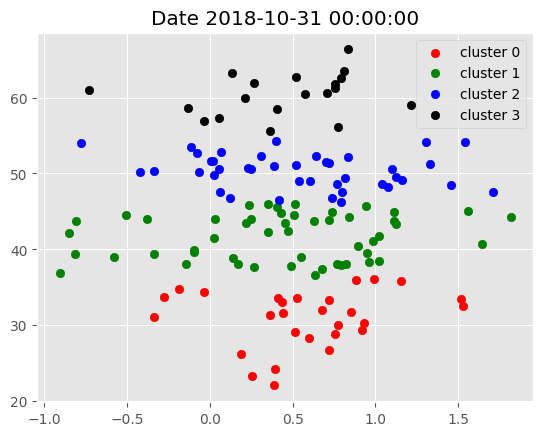

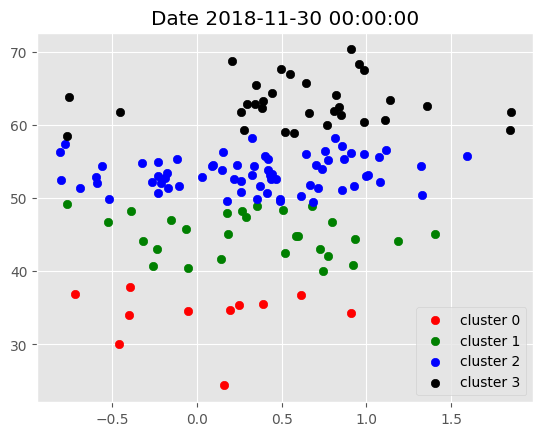

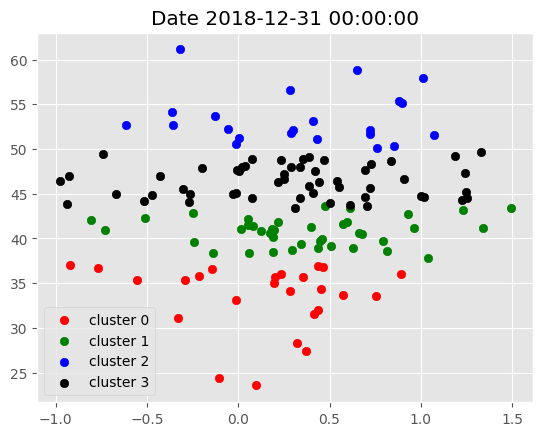

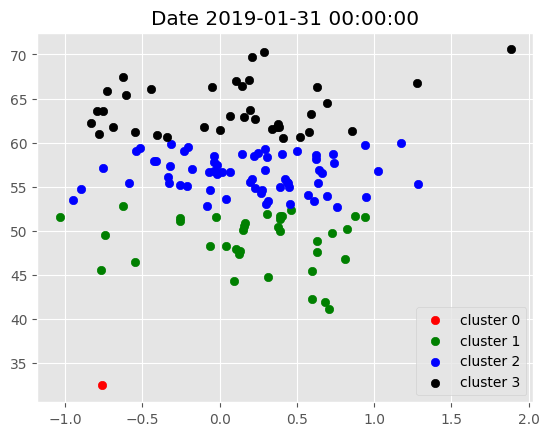

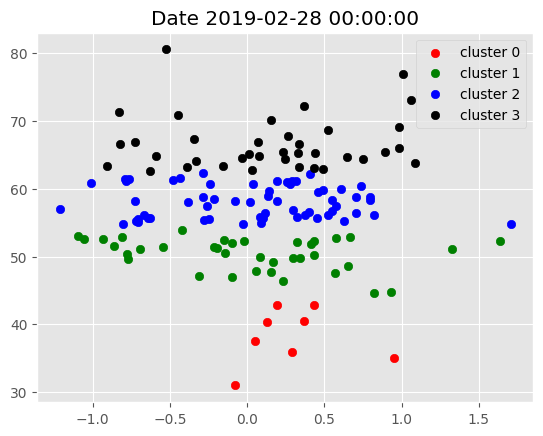

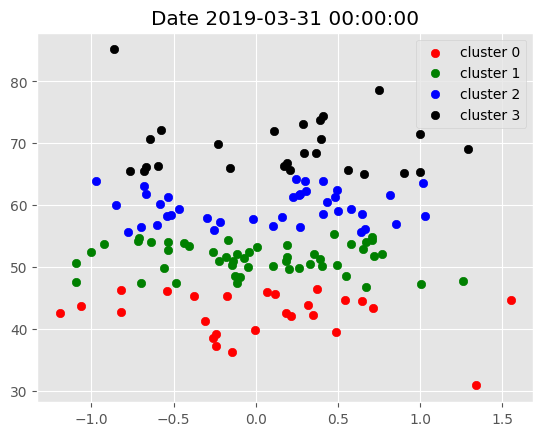

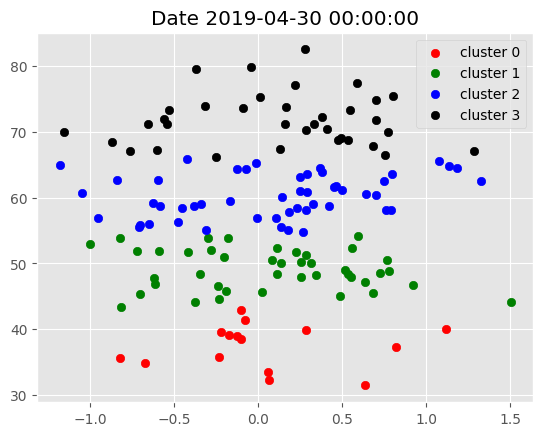

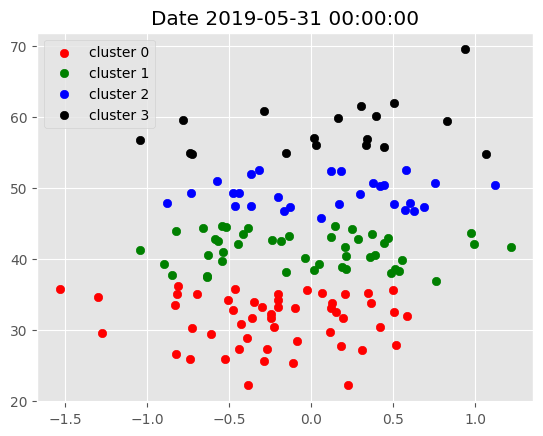

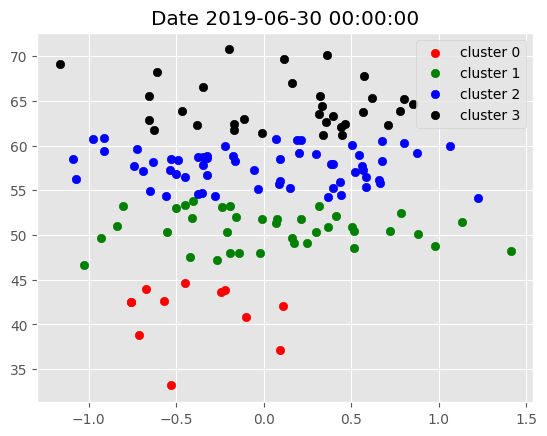

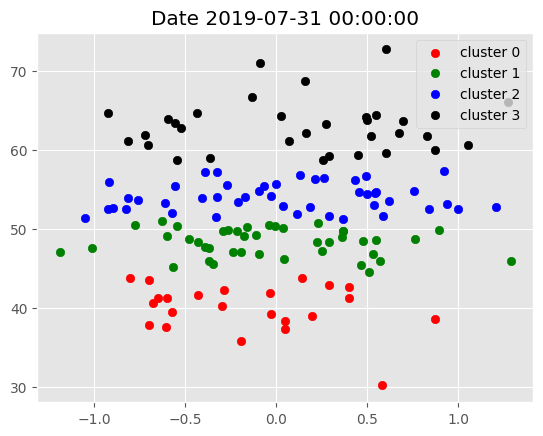

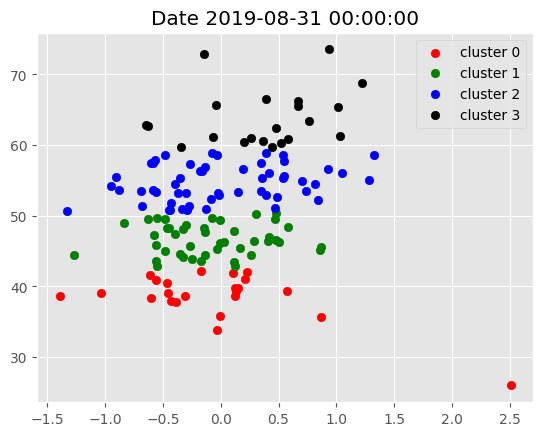

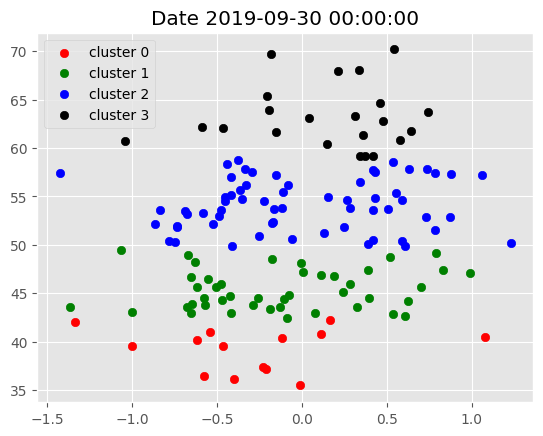

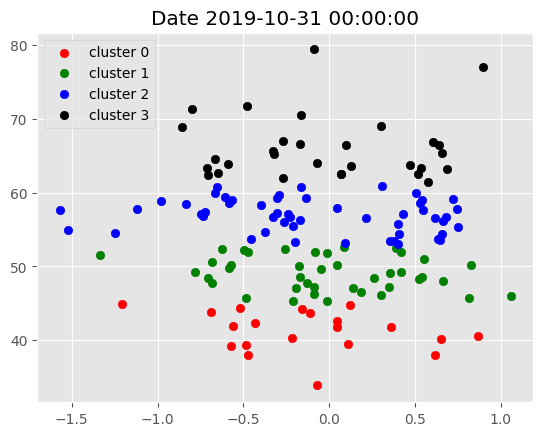

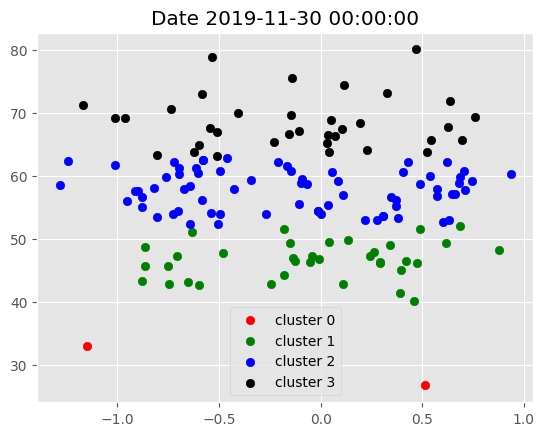

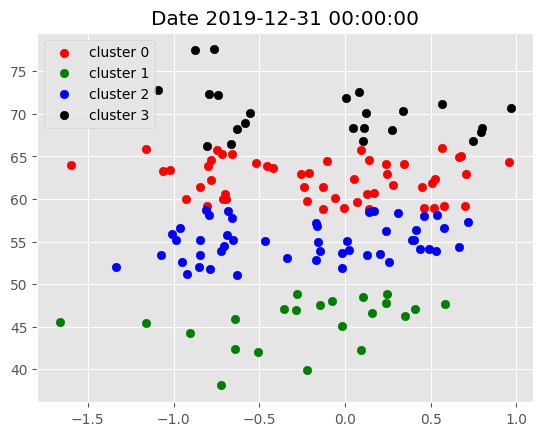

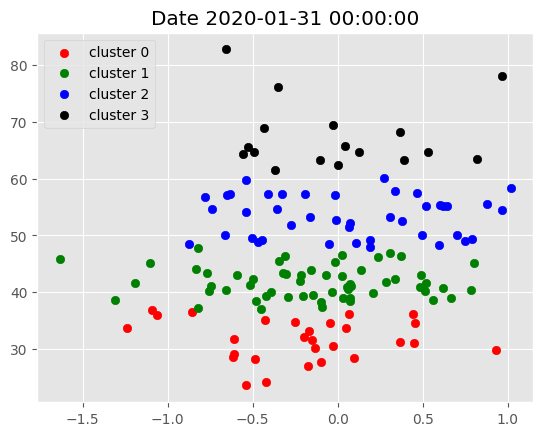

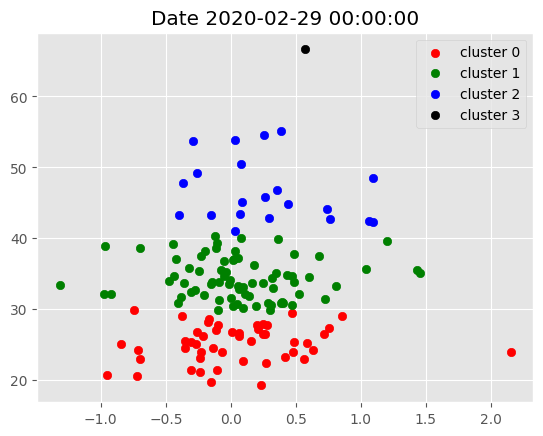

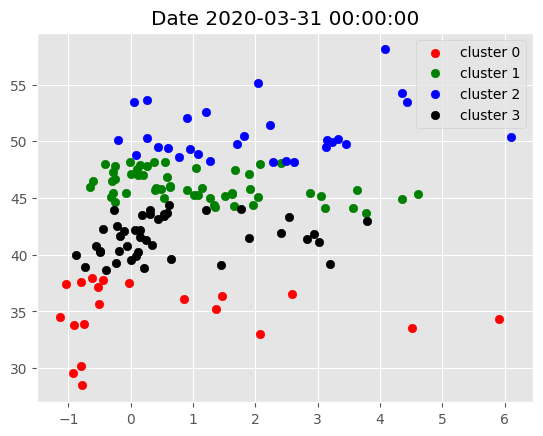

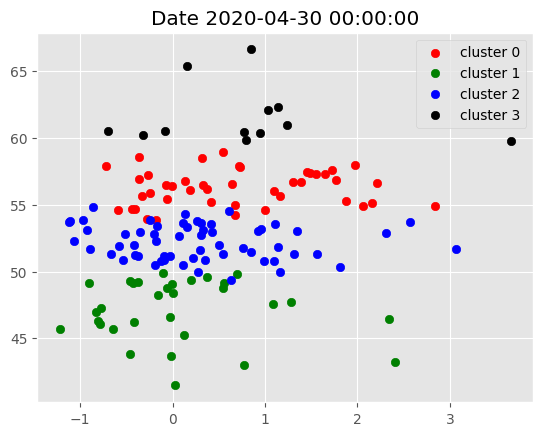

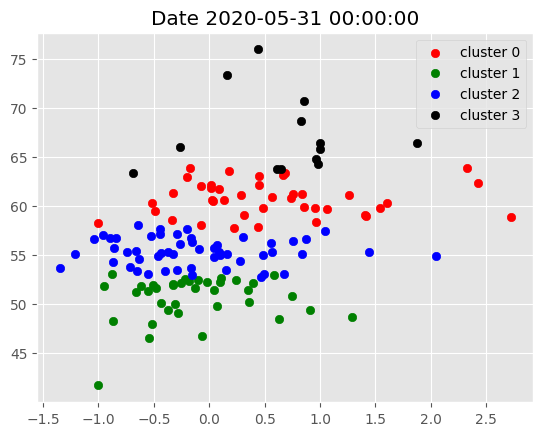

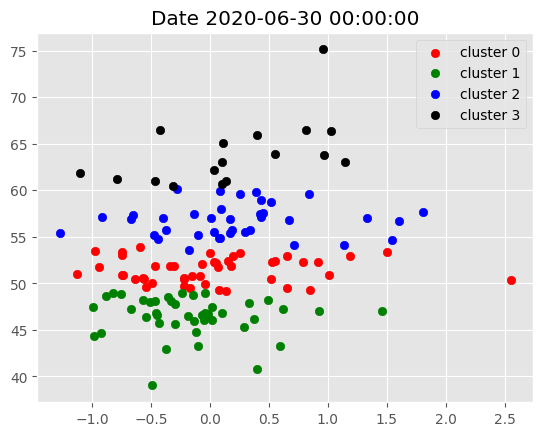

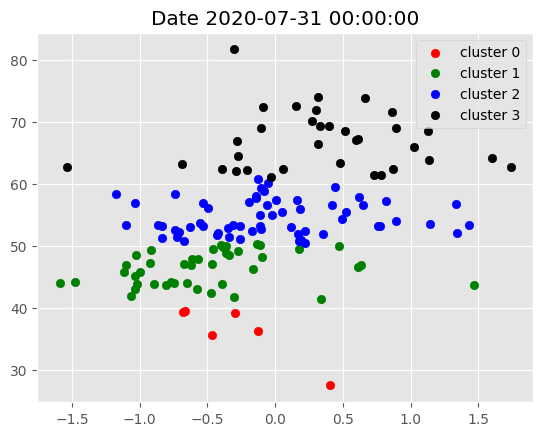

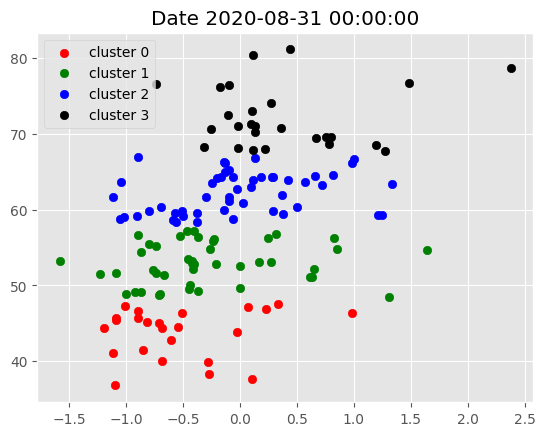

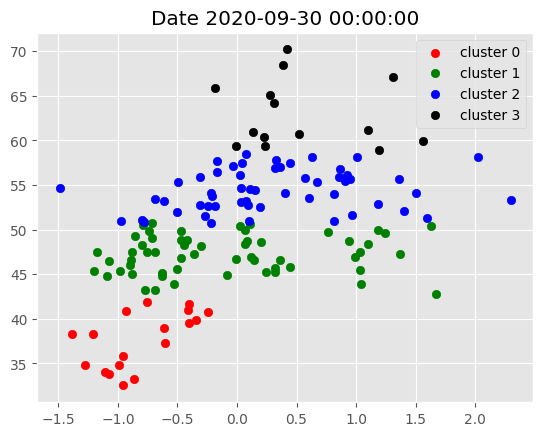

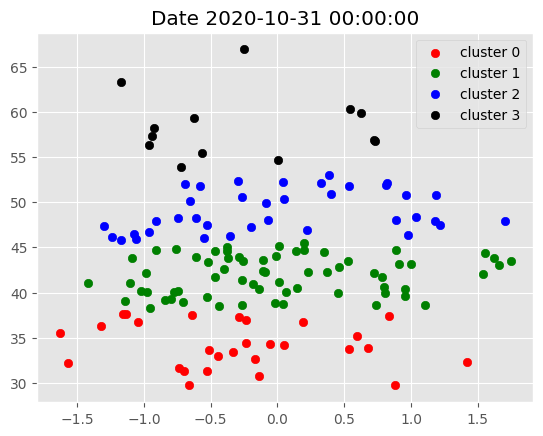

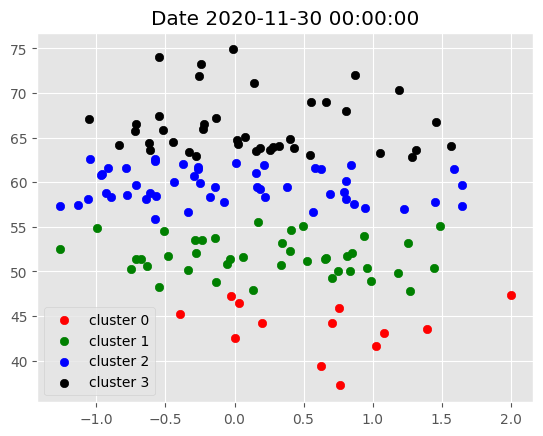

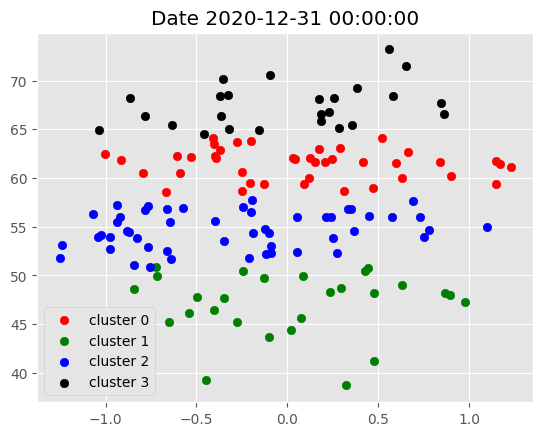

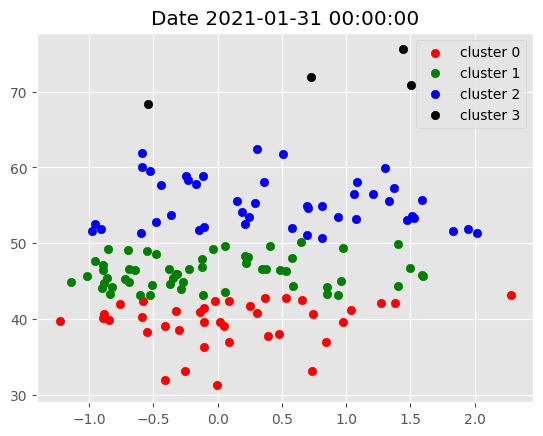

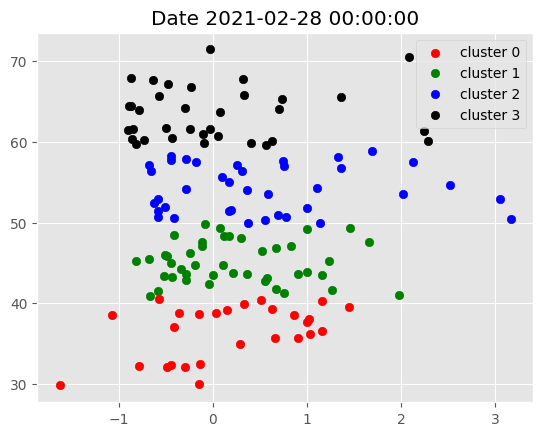

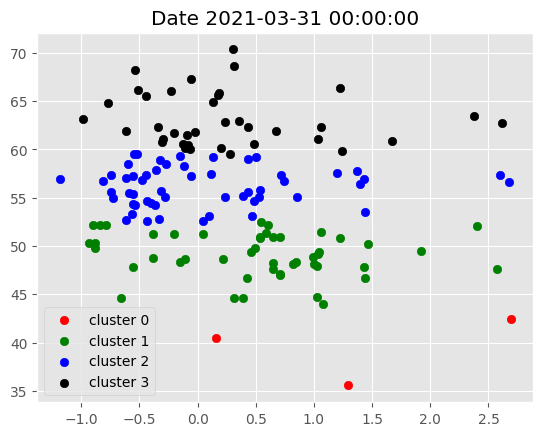

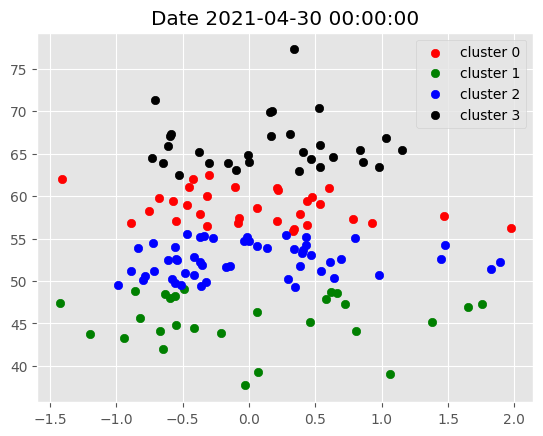

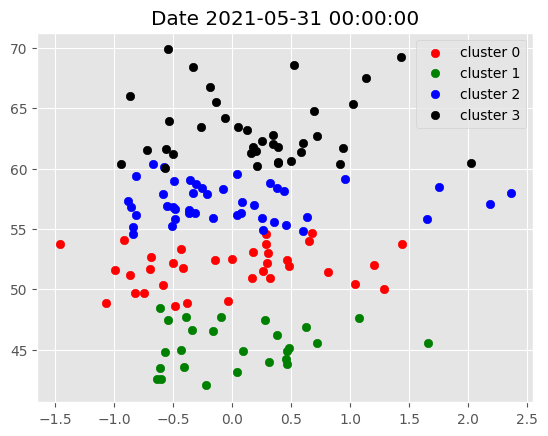

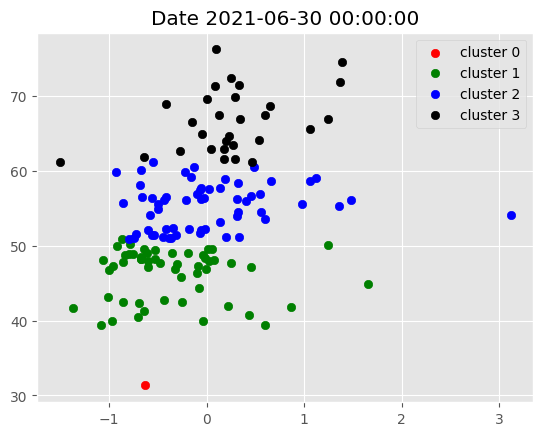

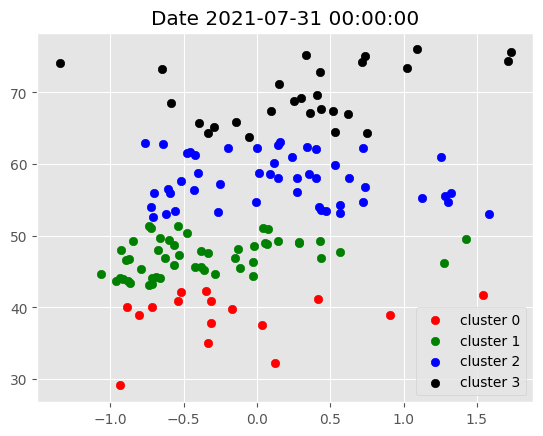

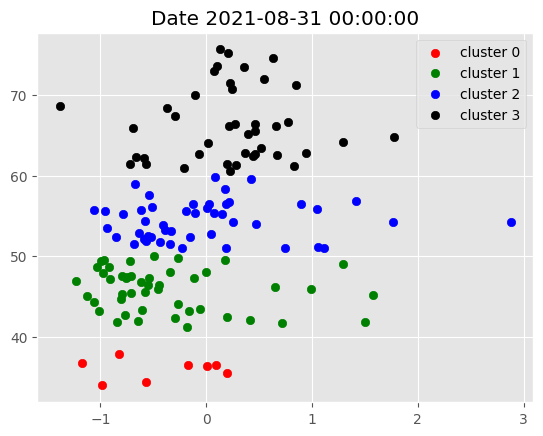

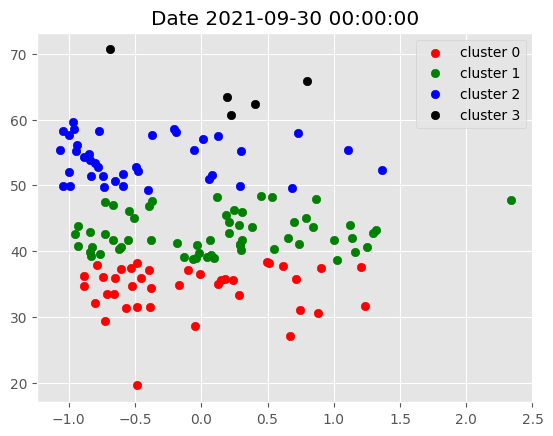

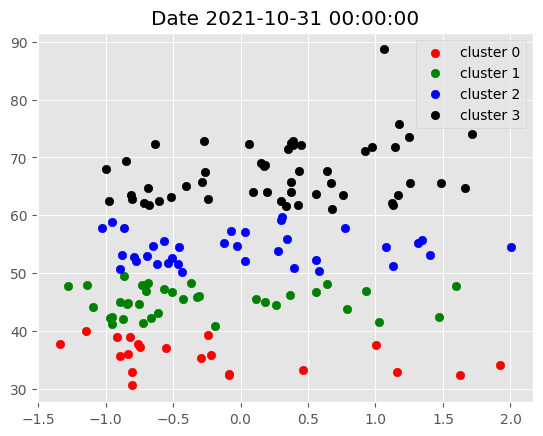

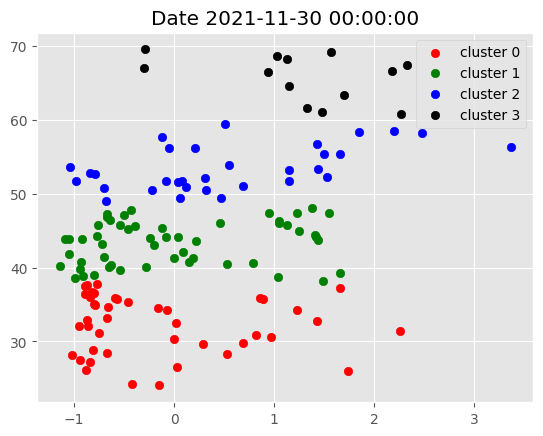

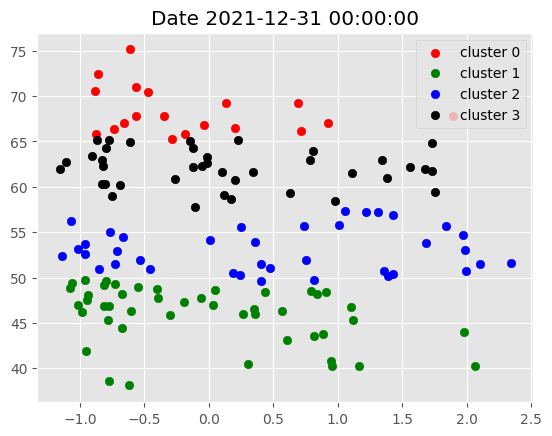

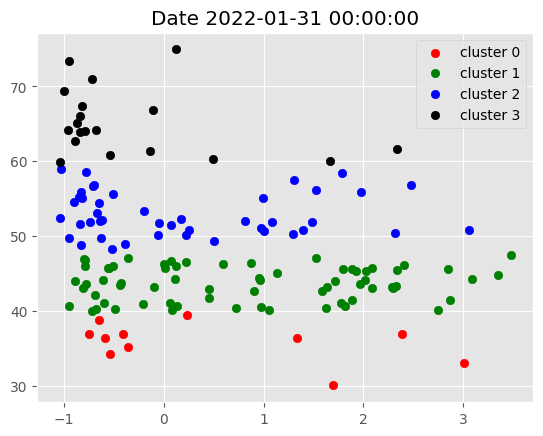

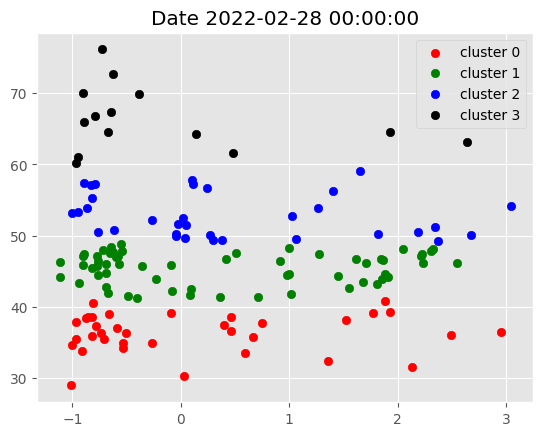

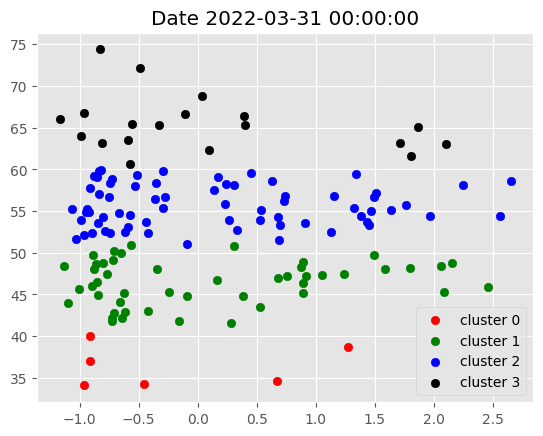

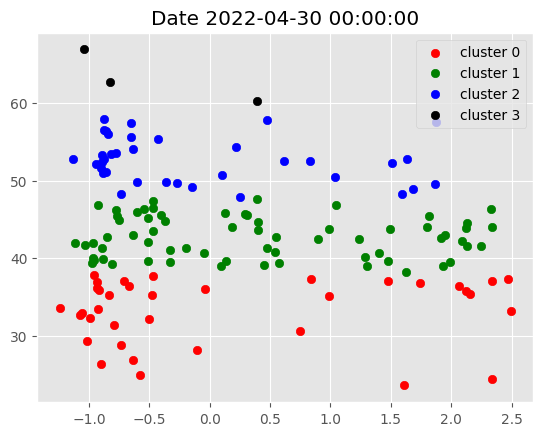

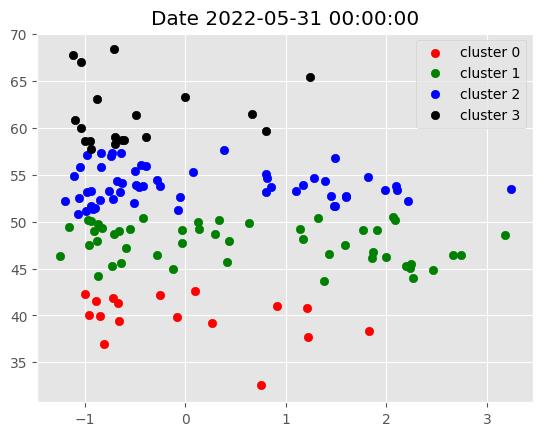

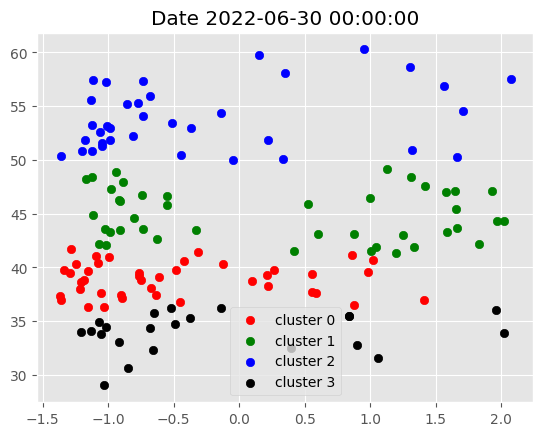

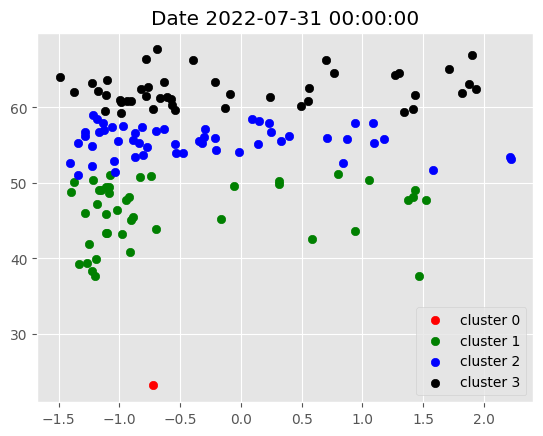

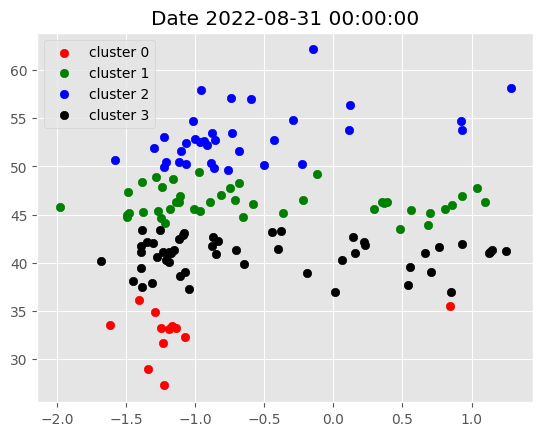

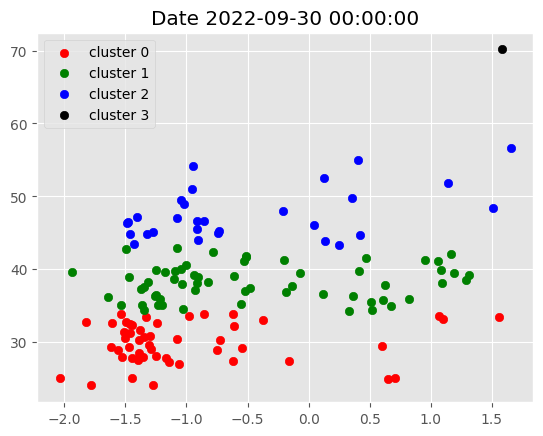

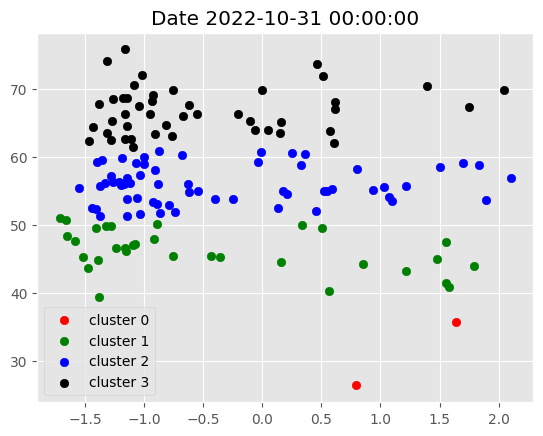

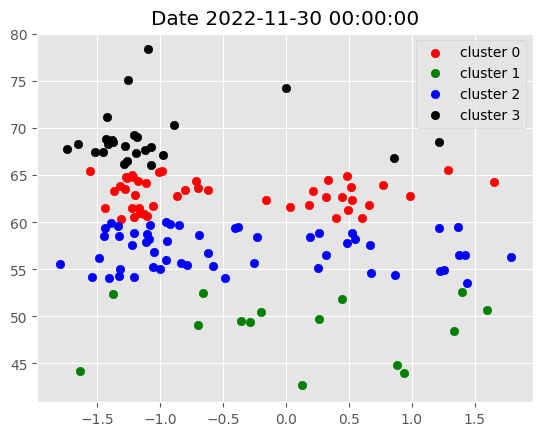

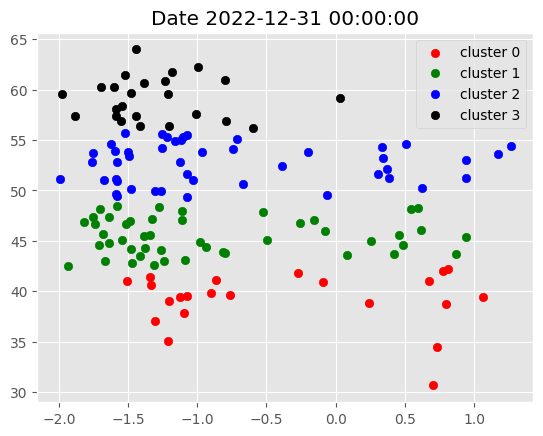

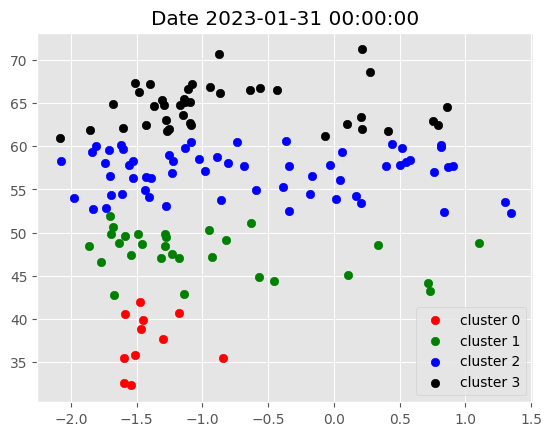

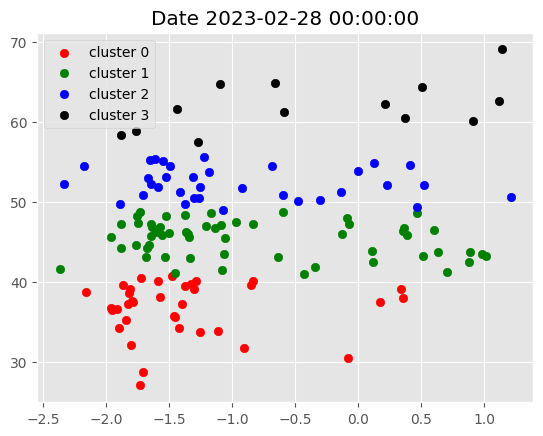

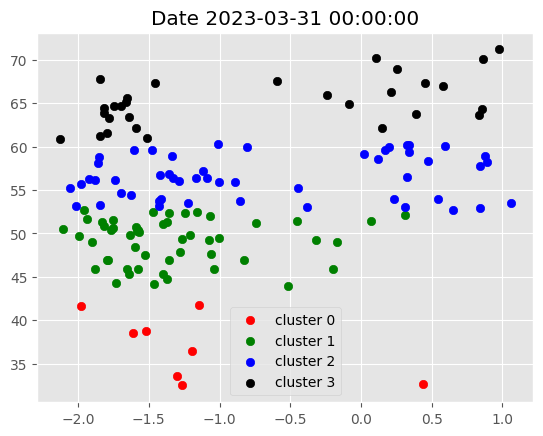

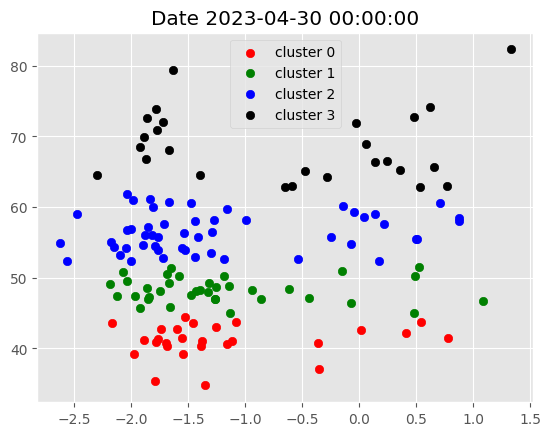

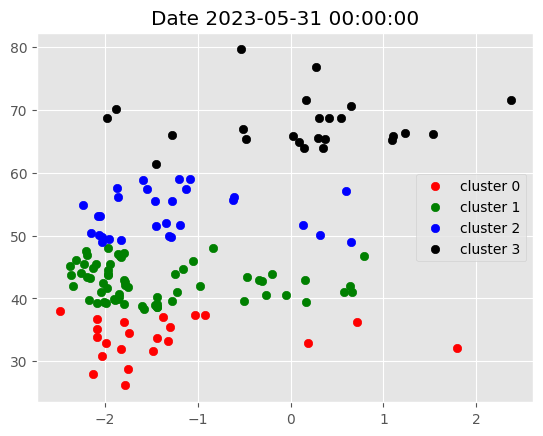

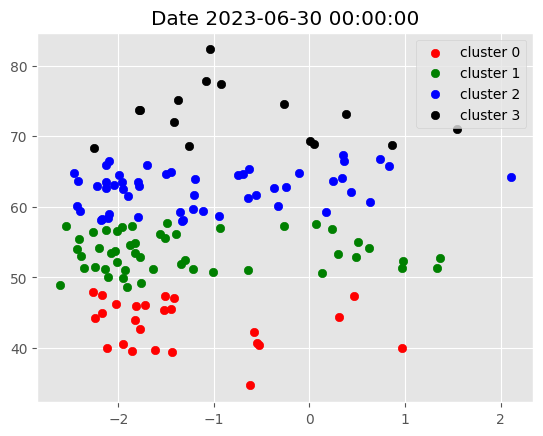

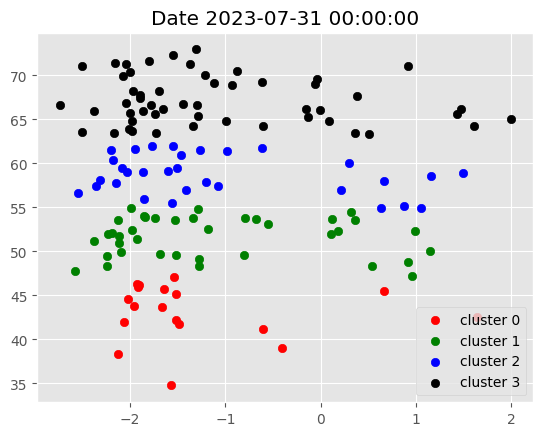

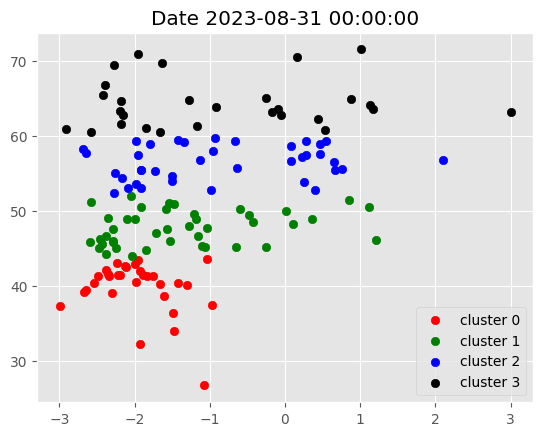

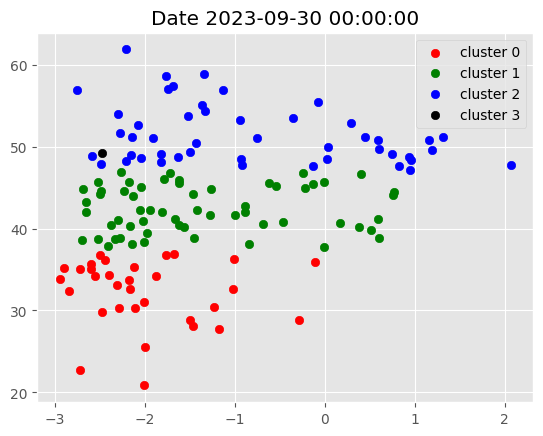

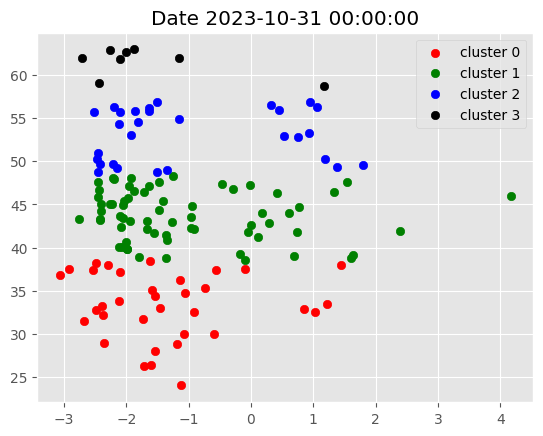

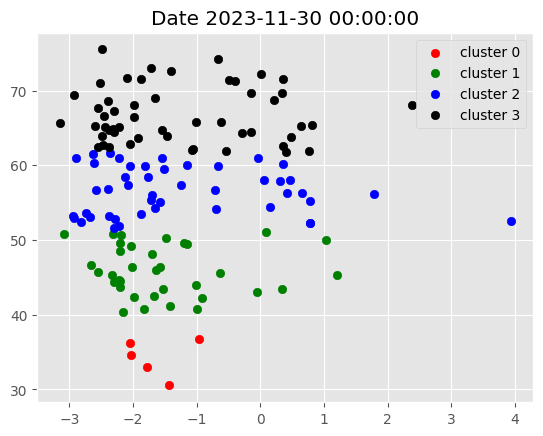

In [130]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f"Date {i}")
    plot_clusters(g)